In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from sipm.sipm import gauss, compound_poisson
from scipy.optimize import curve_fit
from scipy.special import erfc, gamma
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

# Top tile calibration (1101 data)

## Directories

In [4]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/'
bias = [61, 63, 65, 67, 69]
subdir = ['2022-11-01_volt_{}_pos_top_light_laser_coinc_none_cond_calibration/'.format(bias_) for bias_ in bias]

In [5]:
datasets_top = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=4000)
    print(path)
    for i in range(4):
        data.ch[i].read_data(header=True)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].clear()
    datasets_top.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_61_pos_top_light_laser_coinc_none_cond_calibration/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_63_pos_top_light_laser_coinc_none_cond_calibration/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_65_pos_top_light_laser_coinc_none_cond_calibration/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_67_pos_top_light_laser_coinc_none_cond_calibration/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_69_pos_top_light_laser_coinc_none_cond_calibration/


## Plot charge histogram and analyze
Here we look at the raw waveform integrals over $1.6~\mu s$ ($I_{\rm short}$)

/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


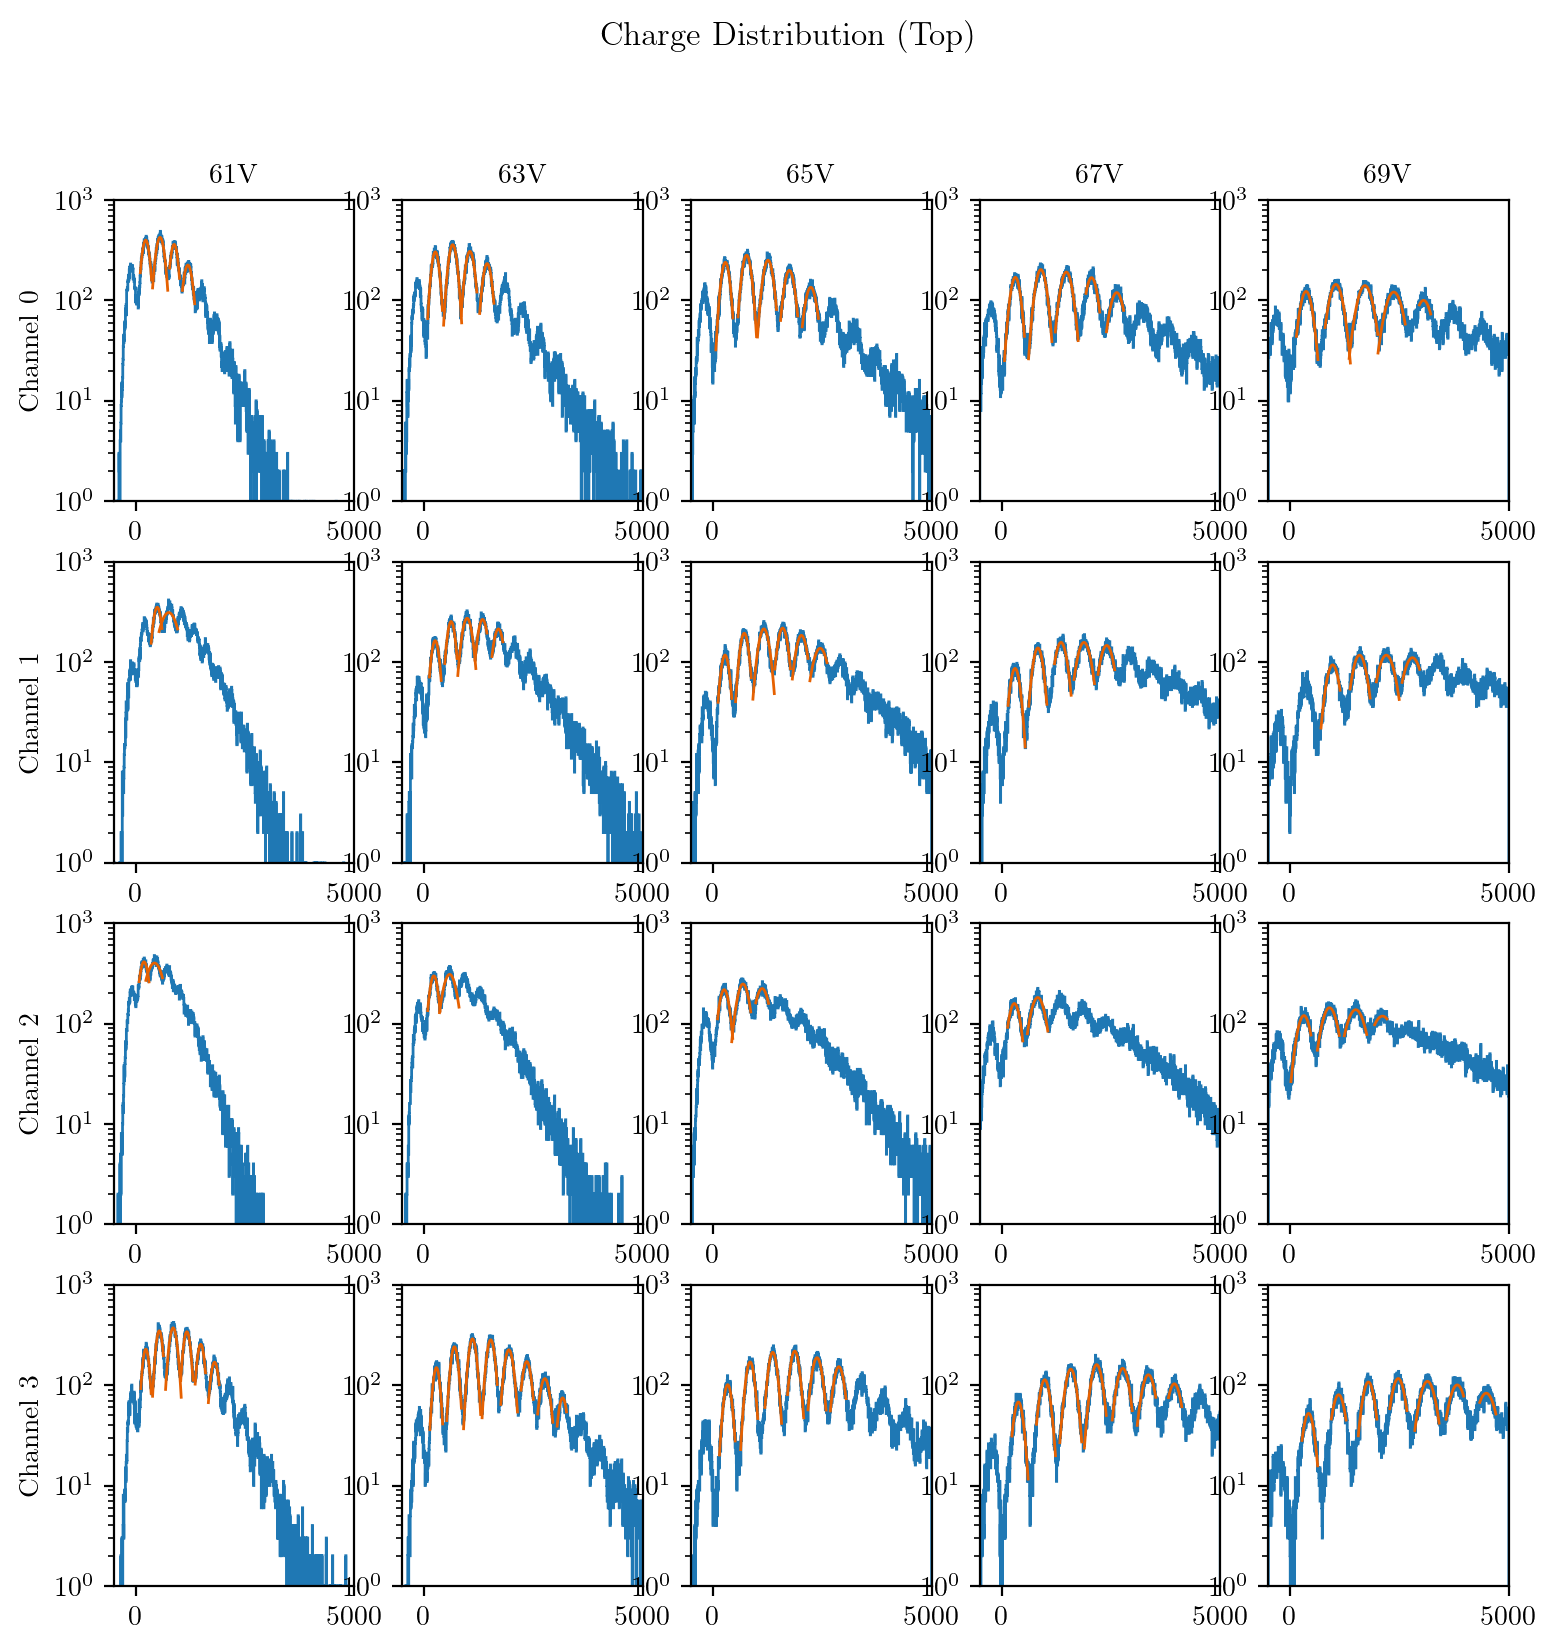

In [6]:
plt.figure(0,figsize=(9,9)) #for charge histograms
# plt.figure(1,figsize=(9,3)) #for breakdown voltage fit
# Vbd_charge_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_top):
        #charge histogram
        data.ch[ch].get_integral_hist(short=[-5e2,5e3,1000], long=[-5e2,5e3,1000])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_short_hist, data.ch[ch].integral_short_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].integral_short_hist_bin[0], data.ch[ch].integral_short_hist_bin[-1])
        plt.ylim(1, 1e3)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='integral_short', thre=100, prom=45, wid=20, dist=20)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='integral_short')
        npe = len(data.ch[ch].integral_short_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].integral_short_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].integral_short_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].integral_short_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        Ishort = [[data.ch[ch].integral_short_hist_fit[k][1][0], data.ch[ch].integral_short_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Ishort)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Ishort)[:,1], maxfev=10000)
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])])
    #breakdown voltage fit and plot
    # xlin = bias
    # ylin = [data.ch[ch].gain_integral[0] for data in datasets_top]
    # err = [data.ch[ch].gain_integral[1] for data in datasets_top]
    # popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], sigma=err, maxfev=10000)
    # print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    # Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    # plt.figure(1)
    # plt.subplot(1,4,ch+1)
    # plt.title('Channel {}'.format(ch))
    # plt.ylabel('Gain (A.U.)')
    # plt.xlabel('Bias (V)')
    # plt.errorbar(xlin,ylin,yerr=err,fmt='o',markersize=2)
    # plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    # plt.xlim(50,80)
    # plt.ylim(0,1000)
        
plt.figure(0)
plt.suptitle('Charge Distribution (Top)')
plt.savefig('plots/sipm/charge_histo_top_1101.pdf')
# plt.figure(1)
# plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('plots/sipm/gain_bias_charge_top_1101.pdf')

## Plot filtered amplitude histogram and analyze
Here we look at the prompt amplitude of AR-filtered waveforms ($A_{\rm filt}$).<br>
The PE peaks in the histograms are fitted with Gaussian $(N_k, A_k, \sigma_k)$, where $k$ is PE count.<br>
$(k, A_k)$ is fitted with linear function $A_k = Q_A \times k  + b$.<br>
$(V, Q_A)$ is then fitted with linear function for breakdown voltage $Q_A = C(V-V_{bd})$.<br>
$(k, N_k)$ is fitted with Vinogradov model (Compound Poisson) where $\mu$ is laser intensity and $p$ is DiCT probability.<br>

mu=2.279 p=0.091
mu=2.524 p=0.147
mu=2.649 p=0.193
mu=2.795 p=0.250
mu=2.836 p=0.316
Channel 0 Vbd=54.991+/-0.058V slope=9.670+/-0.057
mu=3.142 p=0.100
mu=3.502 p=0.150
mu=3.707 p=0.197
mu=3.863 p=0.255
mu=3.963 p=0.300
Channel 1 Vbd=54.927+/-0.091V slope=8.691+/-0.082
mu=2.295 p=0.089
mu=2.585 p=0.129
mu=2.690 p=0.189
mu=2.760 p=0.259
mu=2.878 p=0.300
Channel 2 Vbd=55.201+/-0.114V slope=8.333+/-0.086
mu=3.314 p=0.111
mu=3.683 p=0.156
mu=3.891 p=0.204
mu=4.098 p=0.258
mu=4.141 p=0.324
Channel 3 Vbd=54.824+/-0.099V slope=9.550+/-0.086


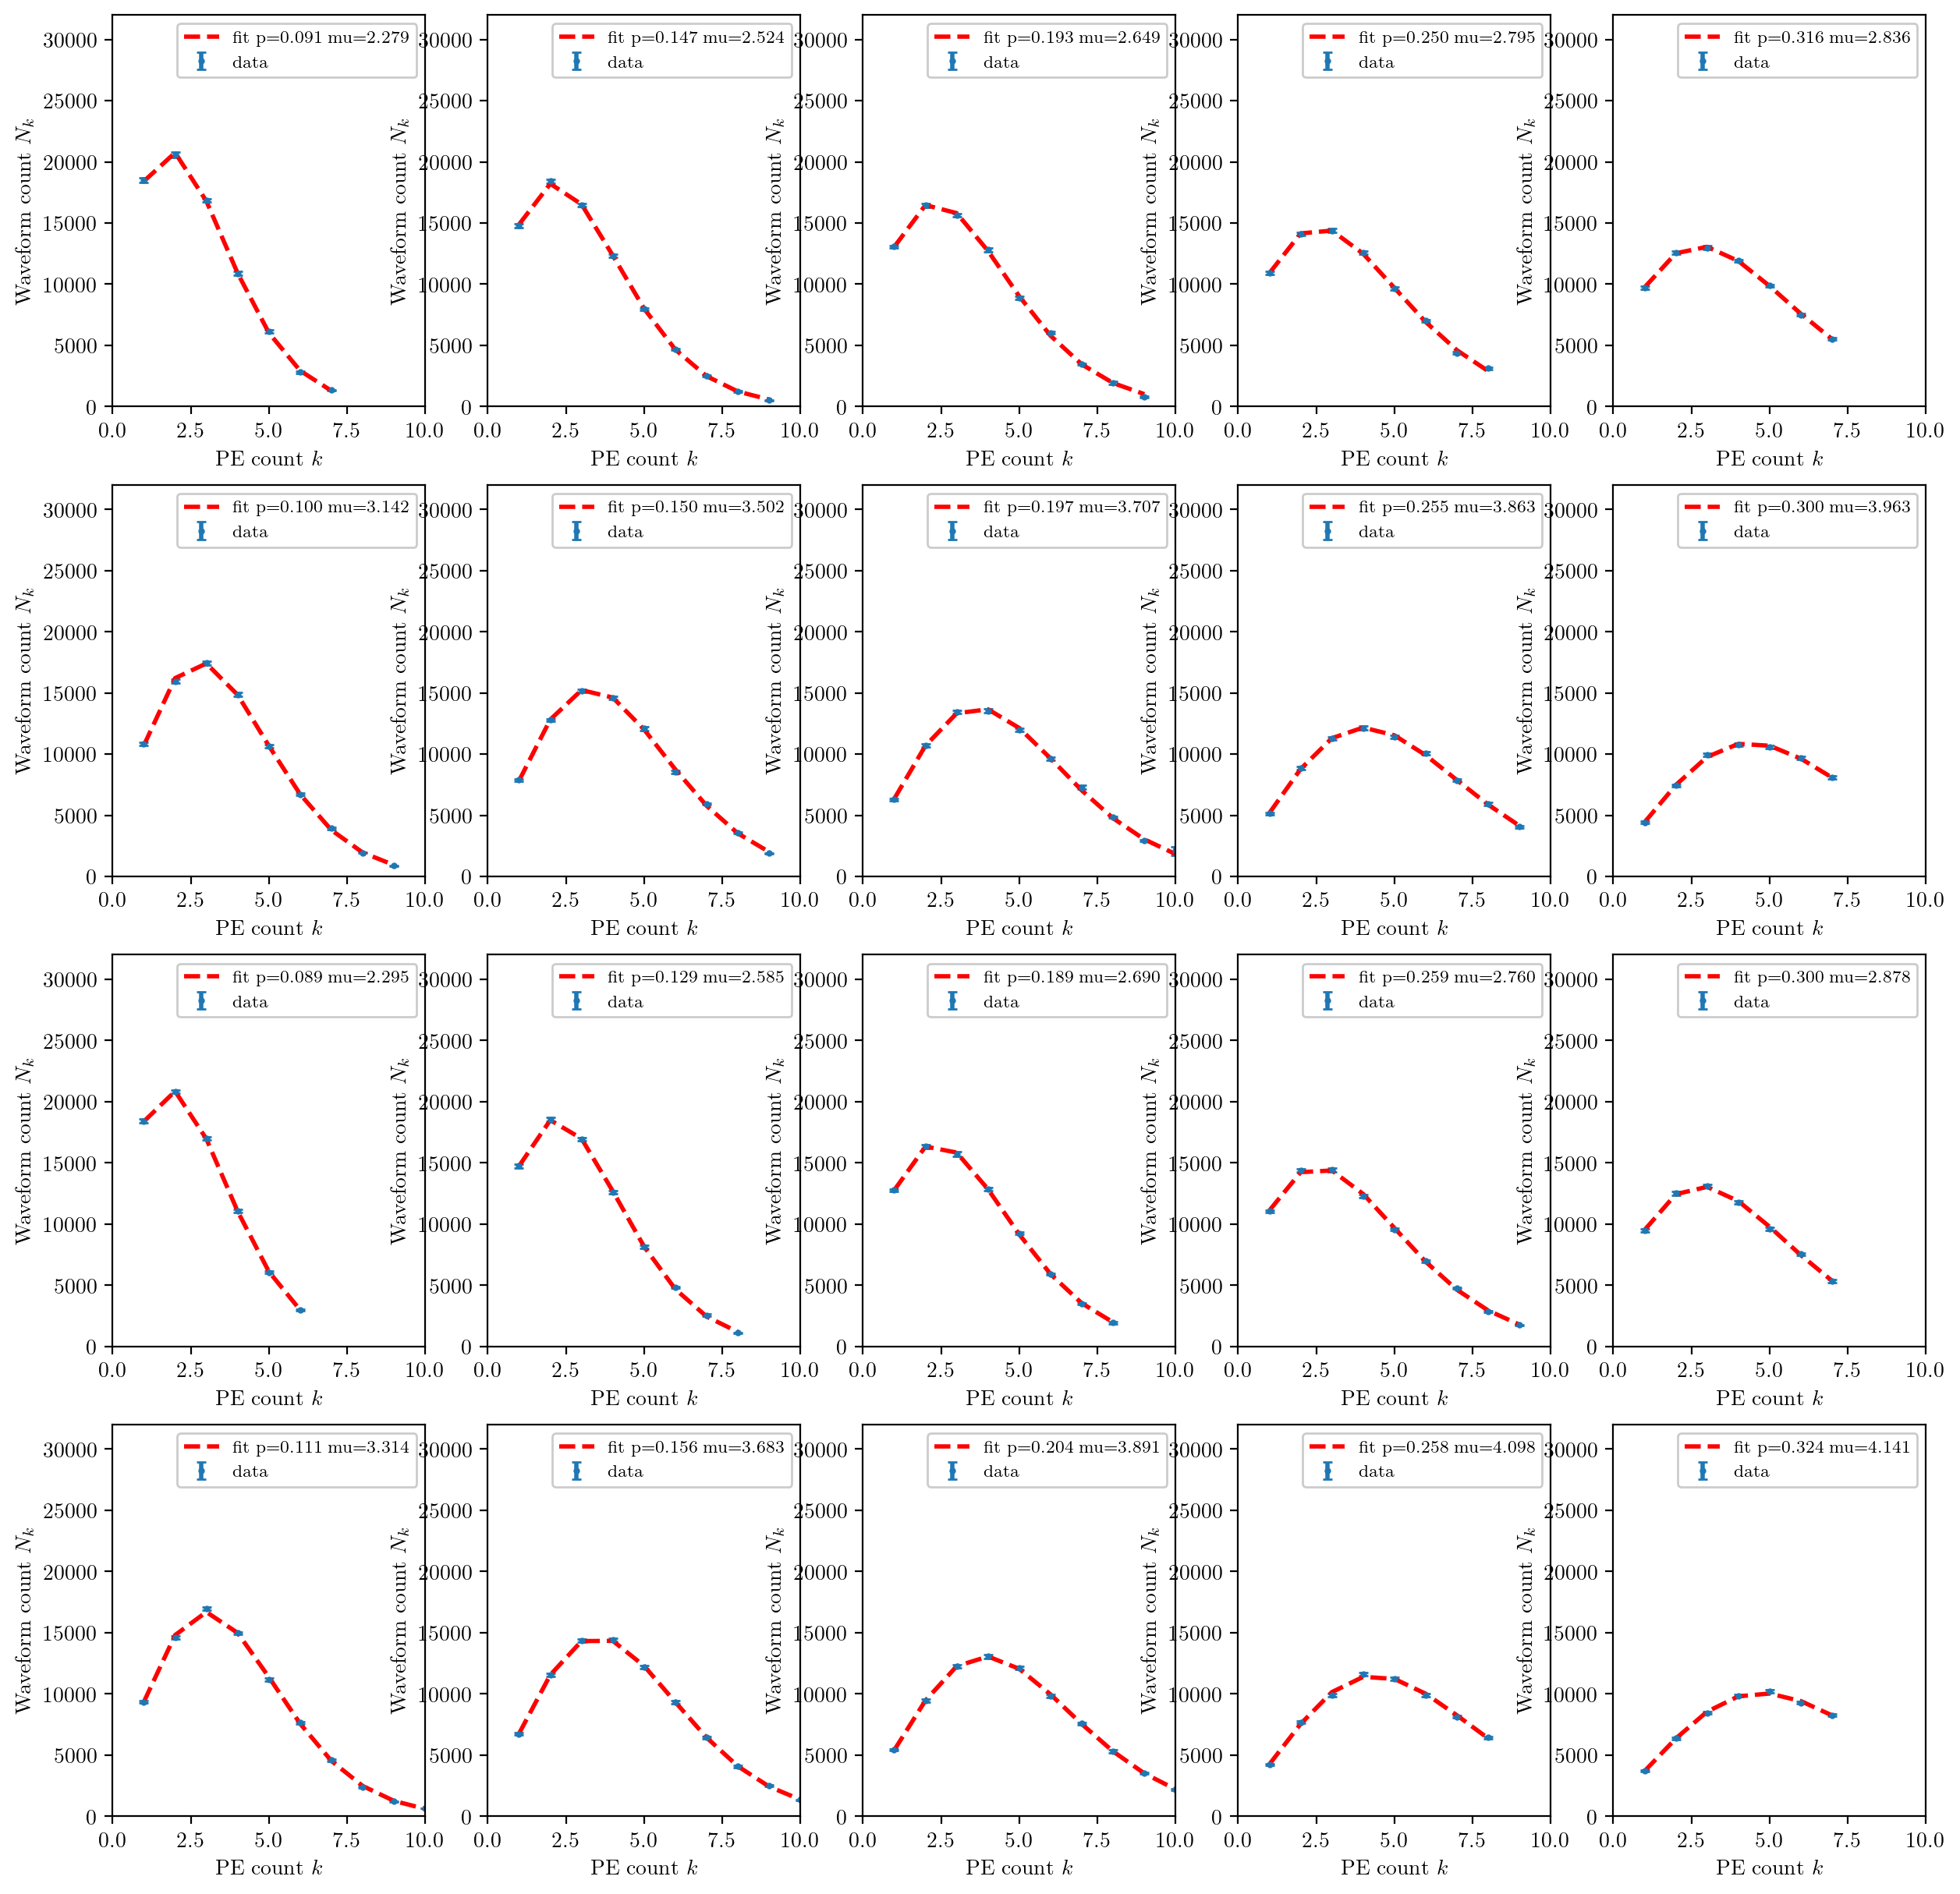

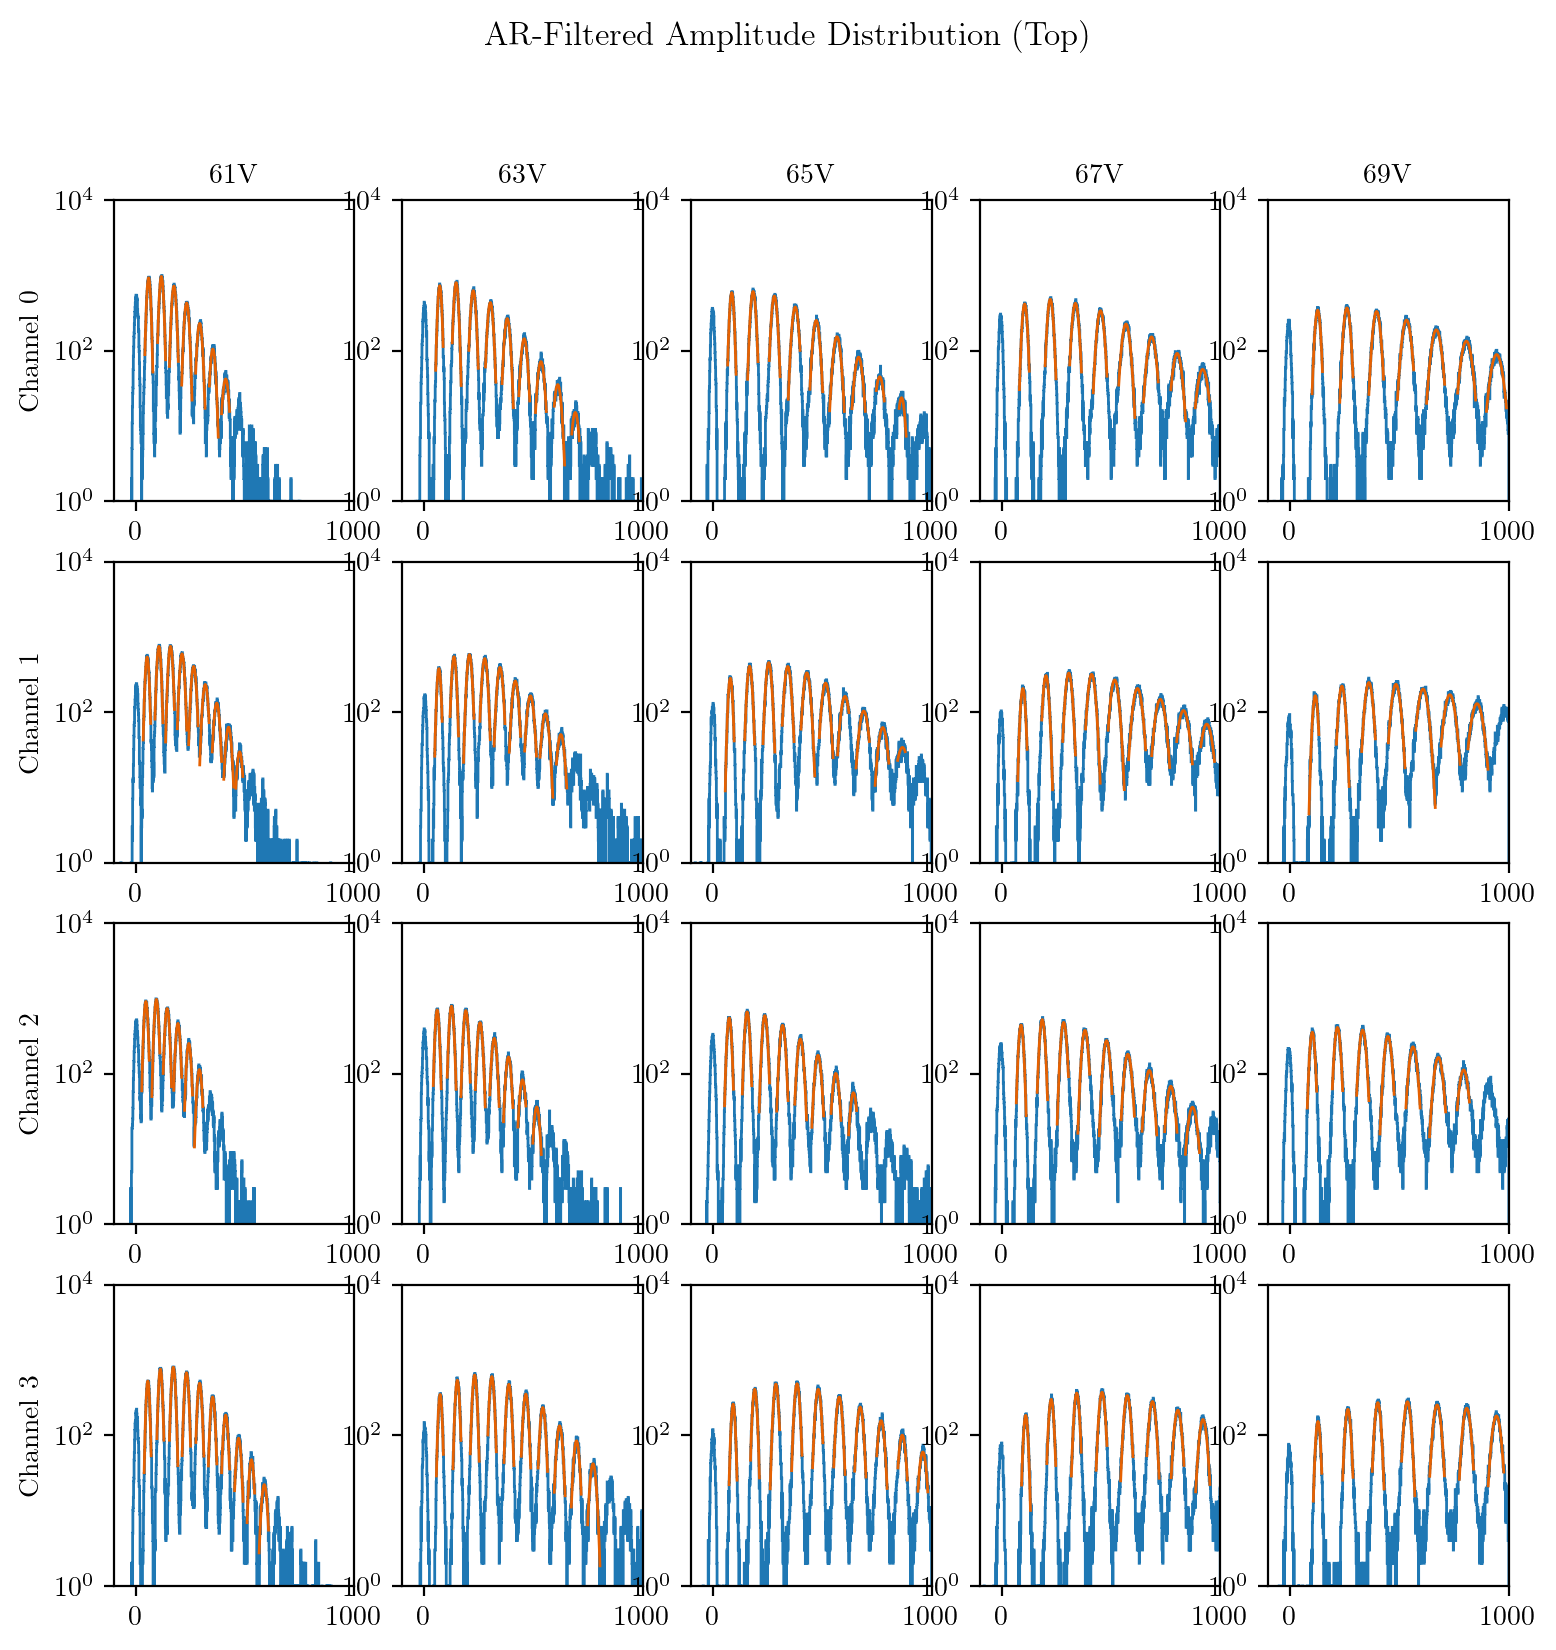

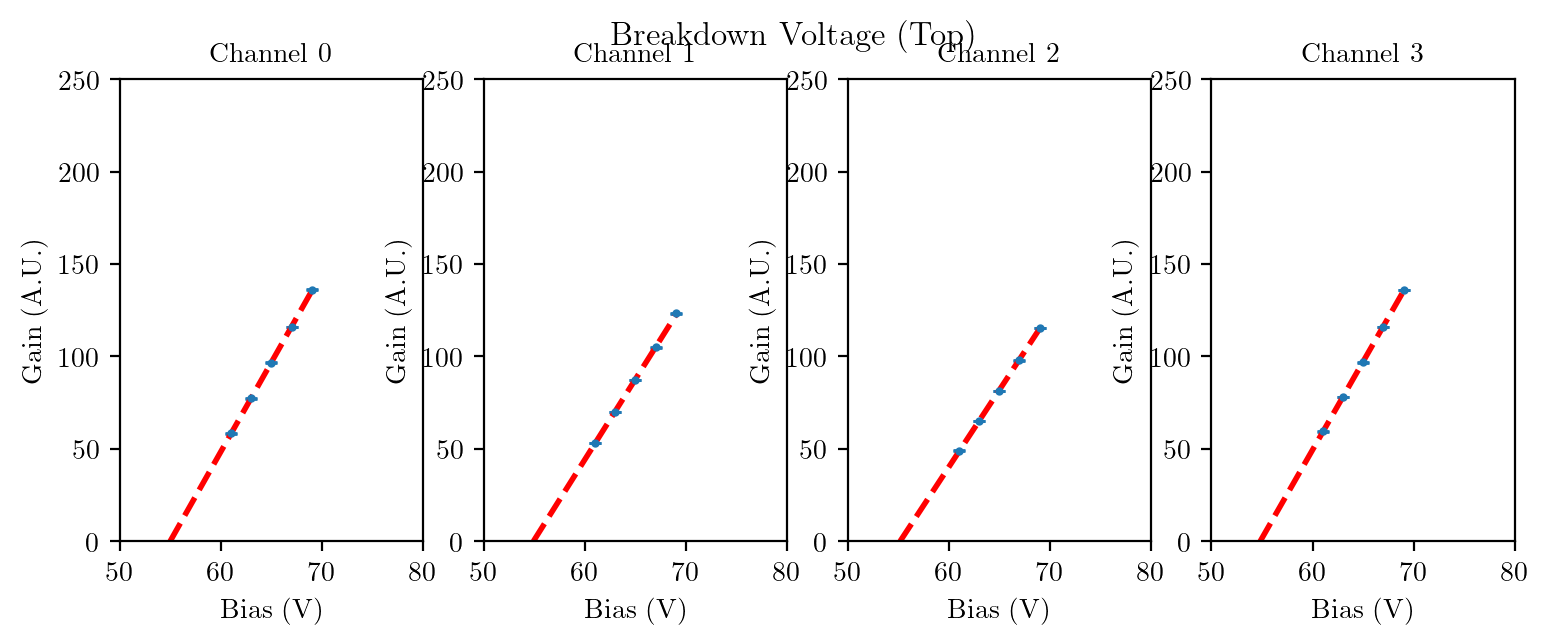

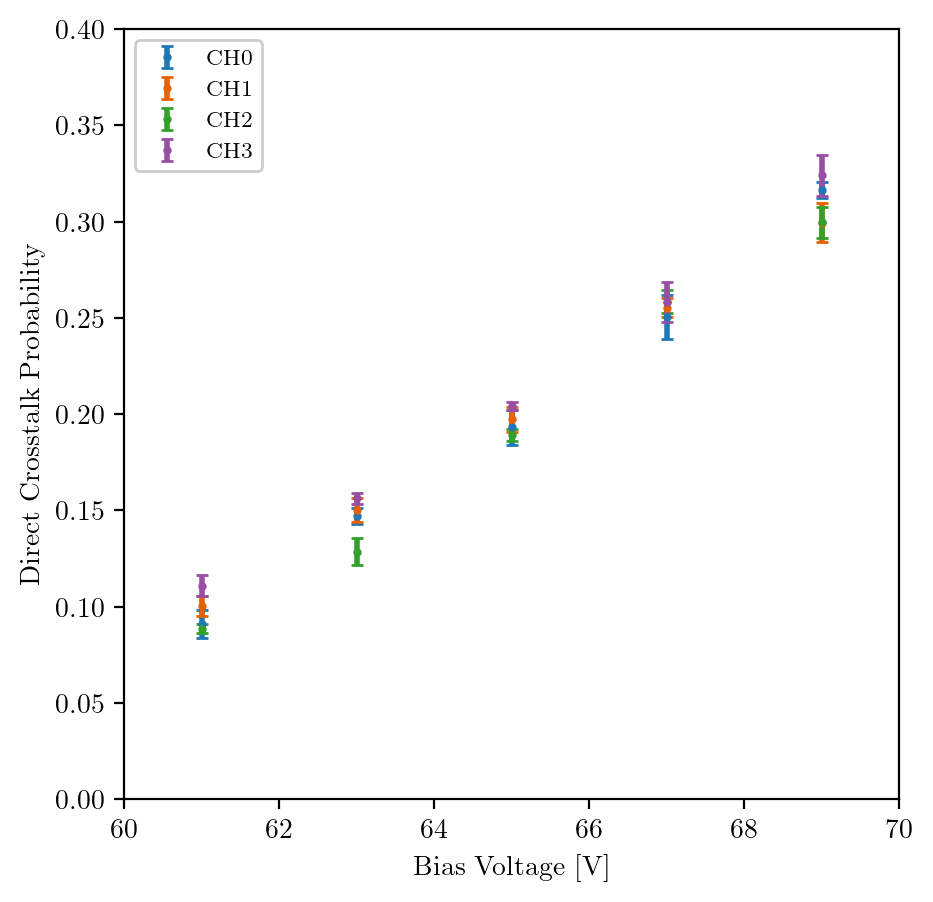

In [7]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
Vbd_famp_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_top):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[-1e2,1e3,1000])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=100, prom=8, wid=15, dist=10)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        npe = len(data.ch[ch].famp_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Afilt)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[data.ch[ch].nevents, 2, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
        print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,0.4*data.ch[ch].nevents)
        plt.xlim(0,10)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in datasets_top], yerr=[data.ch[ch].ct[1] for data in datasets_top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_a[0] for data in datasets_top]
    err = [data.ch[ch].q_a[1] for data in datasets_top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
plt.savefig('plots/sipm/famp_histo_top_1101.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_famp_top_1101.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(60,70)
plt.ylim(0, 0.4)
plt.savefig('plots/sipm/dict_top_1101.pdf')

## Afterpulsing
Here we look at the raw waveform integrals over $5~\mu s$ ($I_{\rm long}$).<br>
They are grouped by the prompt filtered amplitude $A_{\rm filt}$.<br>
If $|A_{\rm filt}-A_k|<3\sigma_k$, assign $I_{\rm long}$ to $I_k$.<br>
$I_k$ is fitted by a Gaussian $(N_{k,\rm peak}, I_{k,\rm peak}, \sigma_{k,\rm peak})$.<br>
$(k, I_k)$ is fitted by a linear function $I_{k,\rm peak} = Q_{\rm peak}\times k + b$.<br>
Define $I_{k,\rm avg}\equiv \overline{I_{k}}$.<br>
$(k, I_{k, \rm avg})$ is fitted by a linear function $I_{k, \rm avg} = Q_{\rm avg} \times k + b$.<br>
Define afterpulse charge $Q_{\rm AP} \equiv \frac{Q_{\rm avg}}{Q_{\rm peak}}-1$.<br>
$Q_{\rm peak}$ is then fitted by the linear function for breakdown voltage $Q_{\rm peak} = C(V-V_{bd})$.<br>

Channel 0 Vbd=53.876+/-0.199V slope=47.299+/-0.799
Channel 1 Vbd=53.783+/-0.199V slope=46.274+/-0.823
Channel 2 Vbd=54.020+/-0.136V slope=46.215+/-0.635
Channel 3 Vbd=53.922+/-0.202V slope=47.119+/-0.916


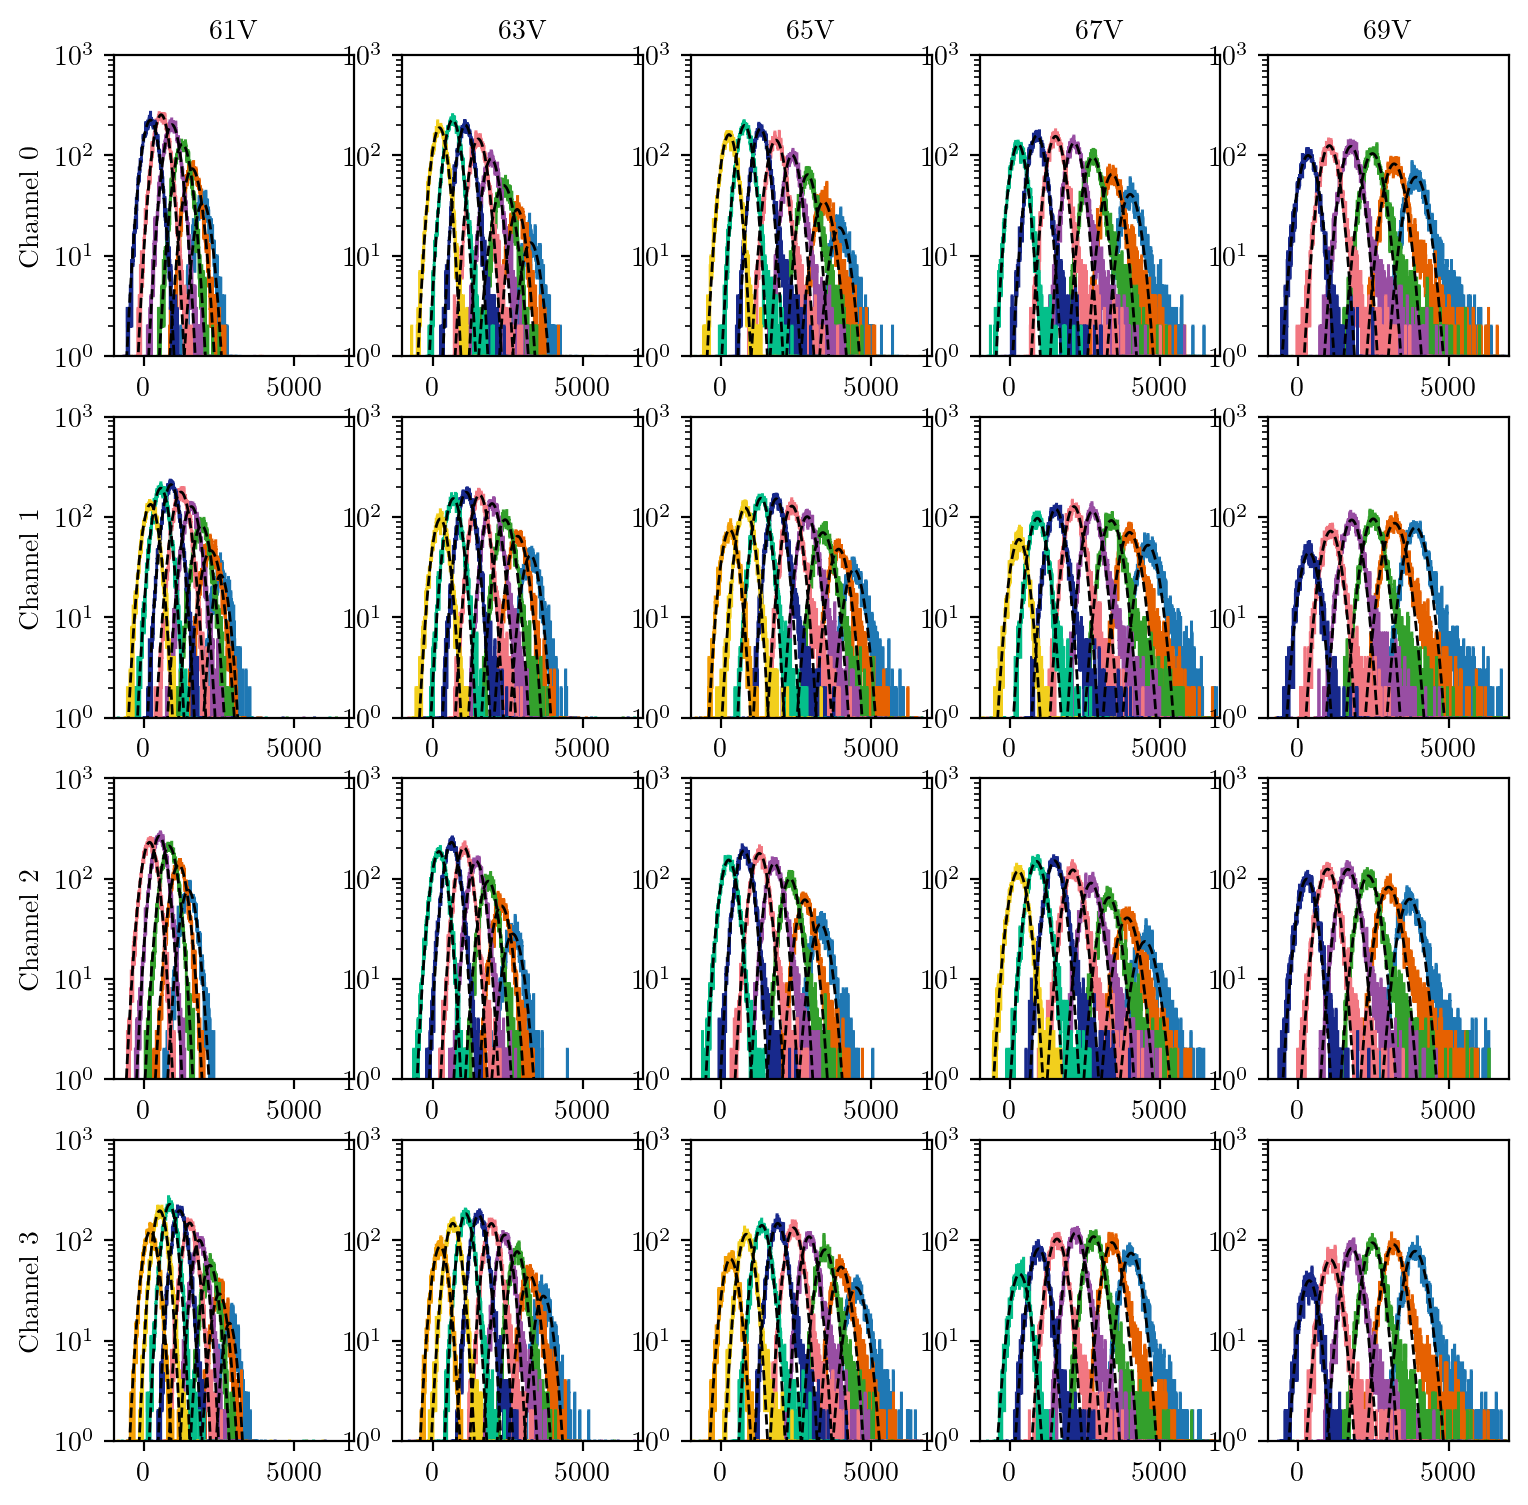

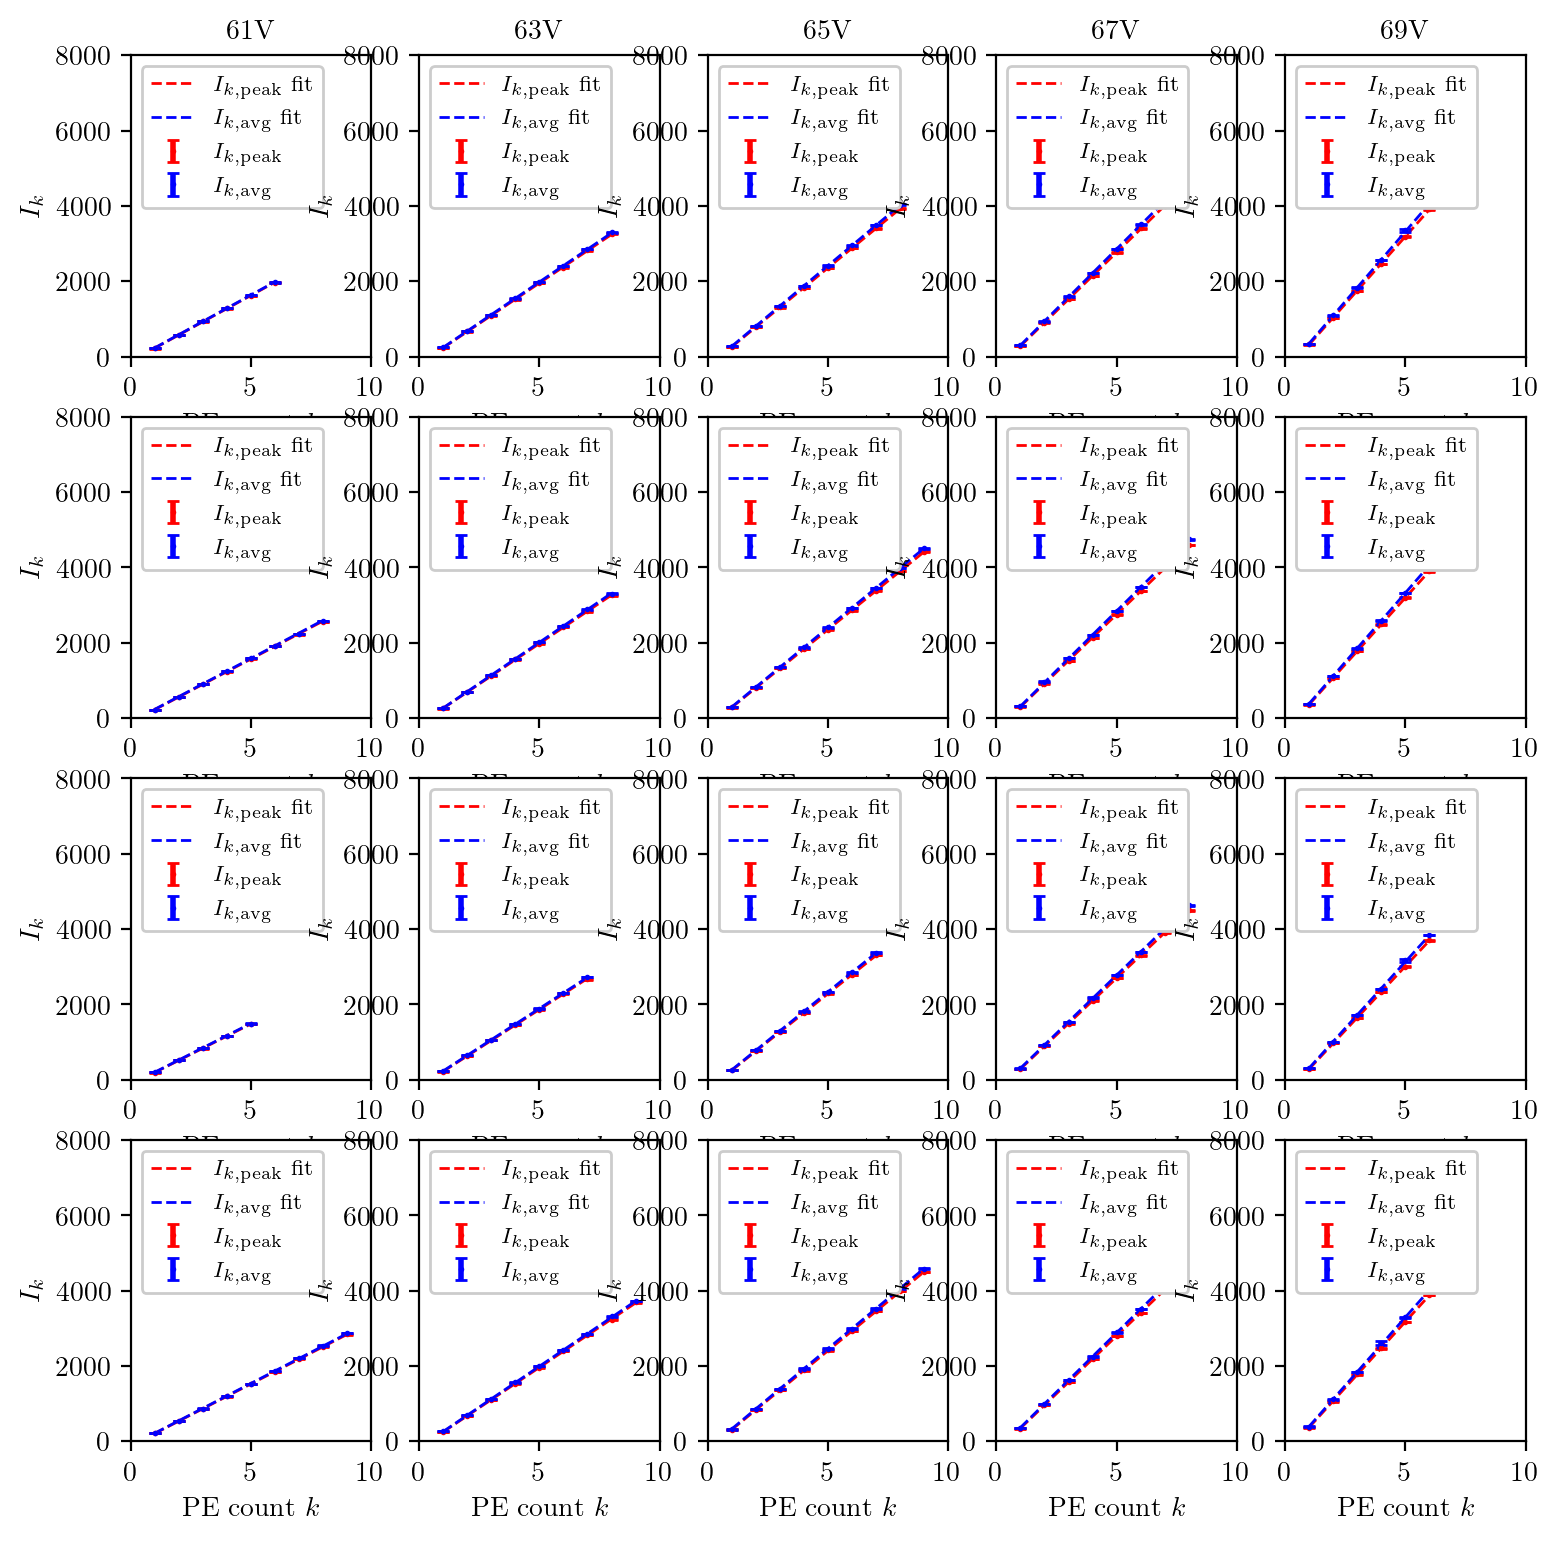

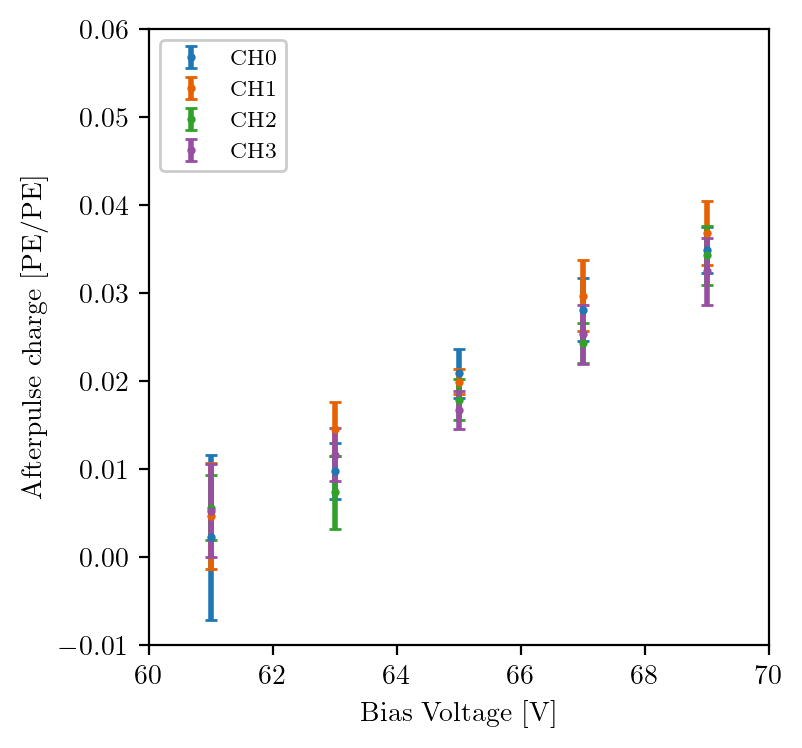

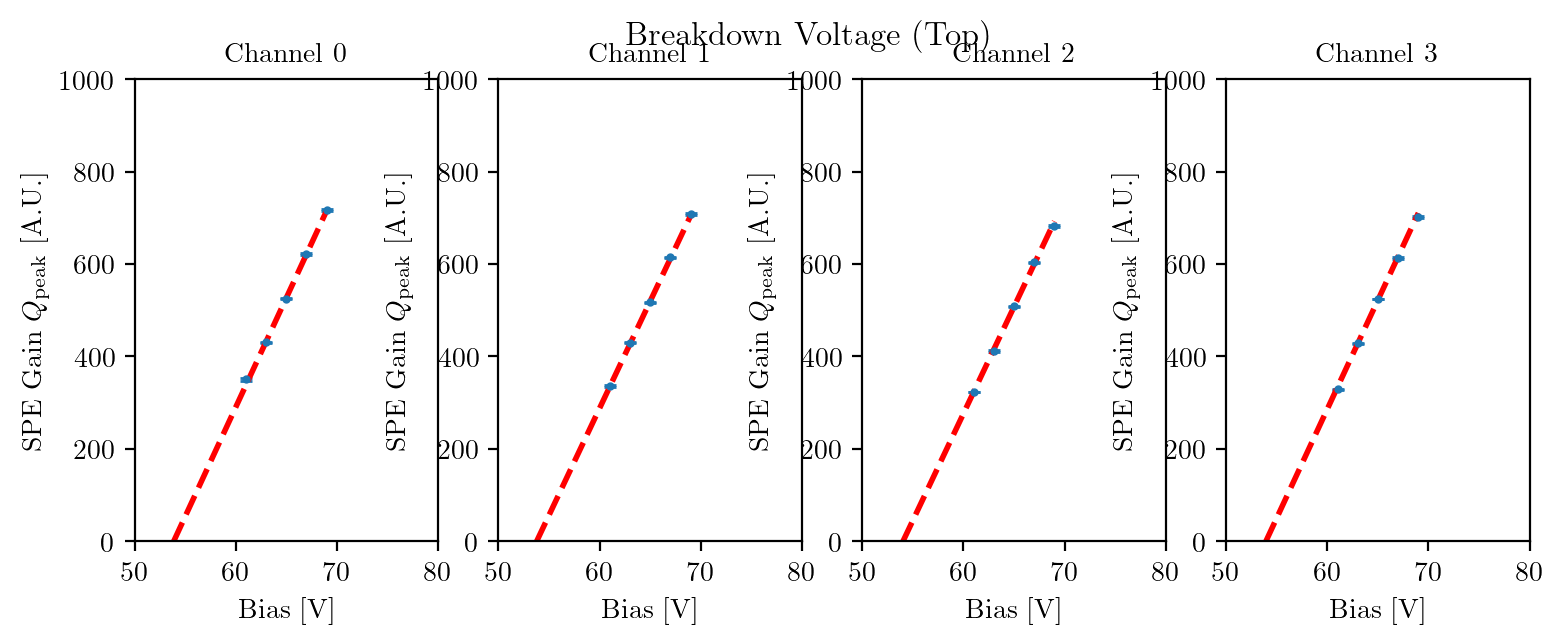

In [8]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
Vbd_charge_top = np.zeros((4,2))
x_min=-1000
x_max=7000
n_bins=1000
bin_width = (x_max-x_min)/n_bins
for ch in range(4):
    for i,data in enumerate(datasets_top):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(nsigma=3, bin=[x_min, x_max, n_bins])
        
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            if w>0.3*(p+x_min/bin_width):
                w=40 # something weird happened so I need to do this
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,1e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in datasets_top], yerr=[data.ch[ch].ap[1] for data in datasets_top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in datasets_top]
    err = [data.ch[ch].q_peak[1] for data in datasets_top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(60,70)
plt.ylim(-0.01, 0.06)
plt.savefig('plots/sipm/afterpulse_bias_top_1101.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_charge_top_1101.pdf')

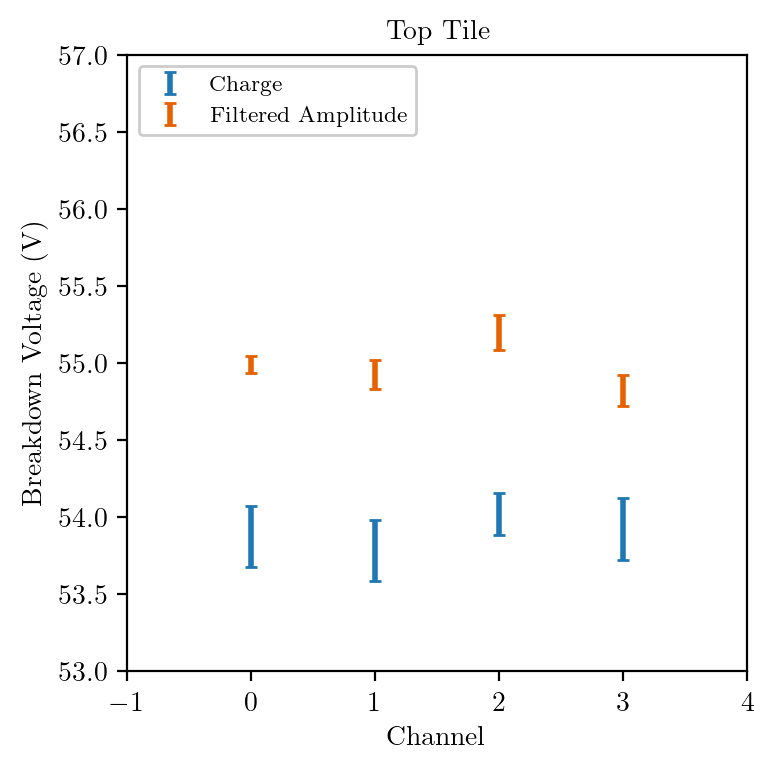

<Figure size 800x600 with 0 Axes>

In [9]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_top[:,0], yerr=Vbd_charge_top[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_top[:,0], yerr=Vbd_famp_top[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Top Tile')
plt.legend()
plt.show()
plt.savefig('plots/sipm/vbd_top_1101.pdf')

## SPE average waveform
Take waveforms with prompt filtered amplitude $|A-A_k|<2\sigma_k$ for $k=1$ and take average.<br>
At $k=1$ PE, afterpulses can be ignored.<br>
The average waveform is fitted by
$$f(t) = A_1 e^{-(t-t_0)/\tau_1} + A_2 e^{-(t-t_0)/\tau2}$$

CH0 61V  A1=1.300+/-0.044 TAU1=0.0312+/-0.0021us A2=2.902+/-0.031 TAU2=0.2967+/-0.0031us
CH0 63V  A1=1.677+/-0.045 TAU1=0.0268+/-0.0014us A2=3.542+/-0.030 TAU2=0.2726+/-0.0023us
CH0 65V  A1=2.004+/-0.054 TAU1=0.0246+/-0.0013us A2=4.496+/-0.037 TAU2=0.2476+/-0.0020us
CH0 67V  A1=2.720+/-0.074 TAU1=0.0252+/-0.0014us A2=5.533+/-0.057 TAU2=0.2243+/-0.0021us
CH0 69V  A1=2.317+/-0.100 TAU1=0.0224+/-0.0019us A2=7.241+/-0.077 TAU2=0.2017+/-0.0020us
CH1 61V  A1=2.601+/-0.050 TAU1=0.0933+/-0.0033us A2=1.033+/-0.050 TAU2=0.5758+/-0.0235us
CH1 63V  A1=3.388+/-0.062 TAU1=0.0878+/-0.0029us A2=1.388+/-0.064 TAU2=0.5026+/-0.0184us
CH1 65V  A1=4.016+/-0.080 TAU1=0.0812+/-0.0028us A2=1.784+/-0.083 TAU2=0.4459+/-0.0157us
CH1 67V  A1=4.963+/-0.109 TAU1=0.0686+/-0.0025us A2=2.495+/-0.114 TAU2=0.3545+/-0.0117us
CH1 69V  A1=5.577+/-0.155 TAU1=0.0720+/-0.0030us A2=3.081+/-0.166 TAU2=0.3331+/-0.0121us
CH2 61V  A1=2.434+/-0.034 TAU1=0.0668+/-0.0018us A2=1.063+/-0.029 TAU2=0.5304+/-0.0133us
CH2 63V  A1=3.119+/-0

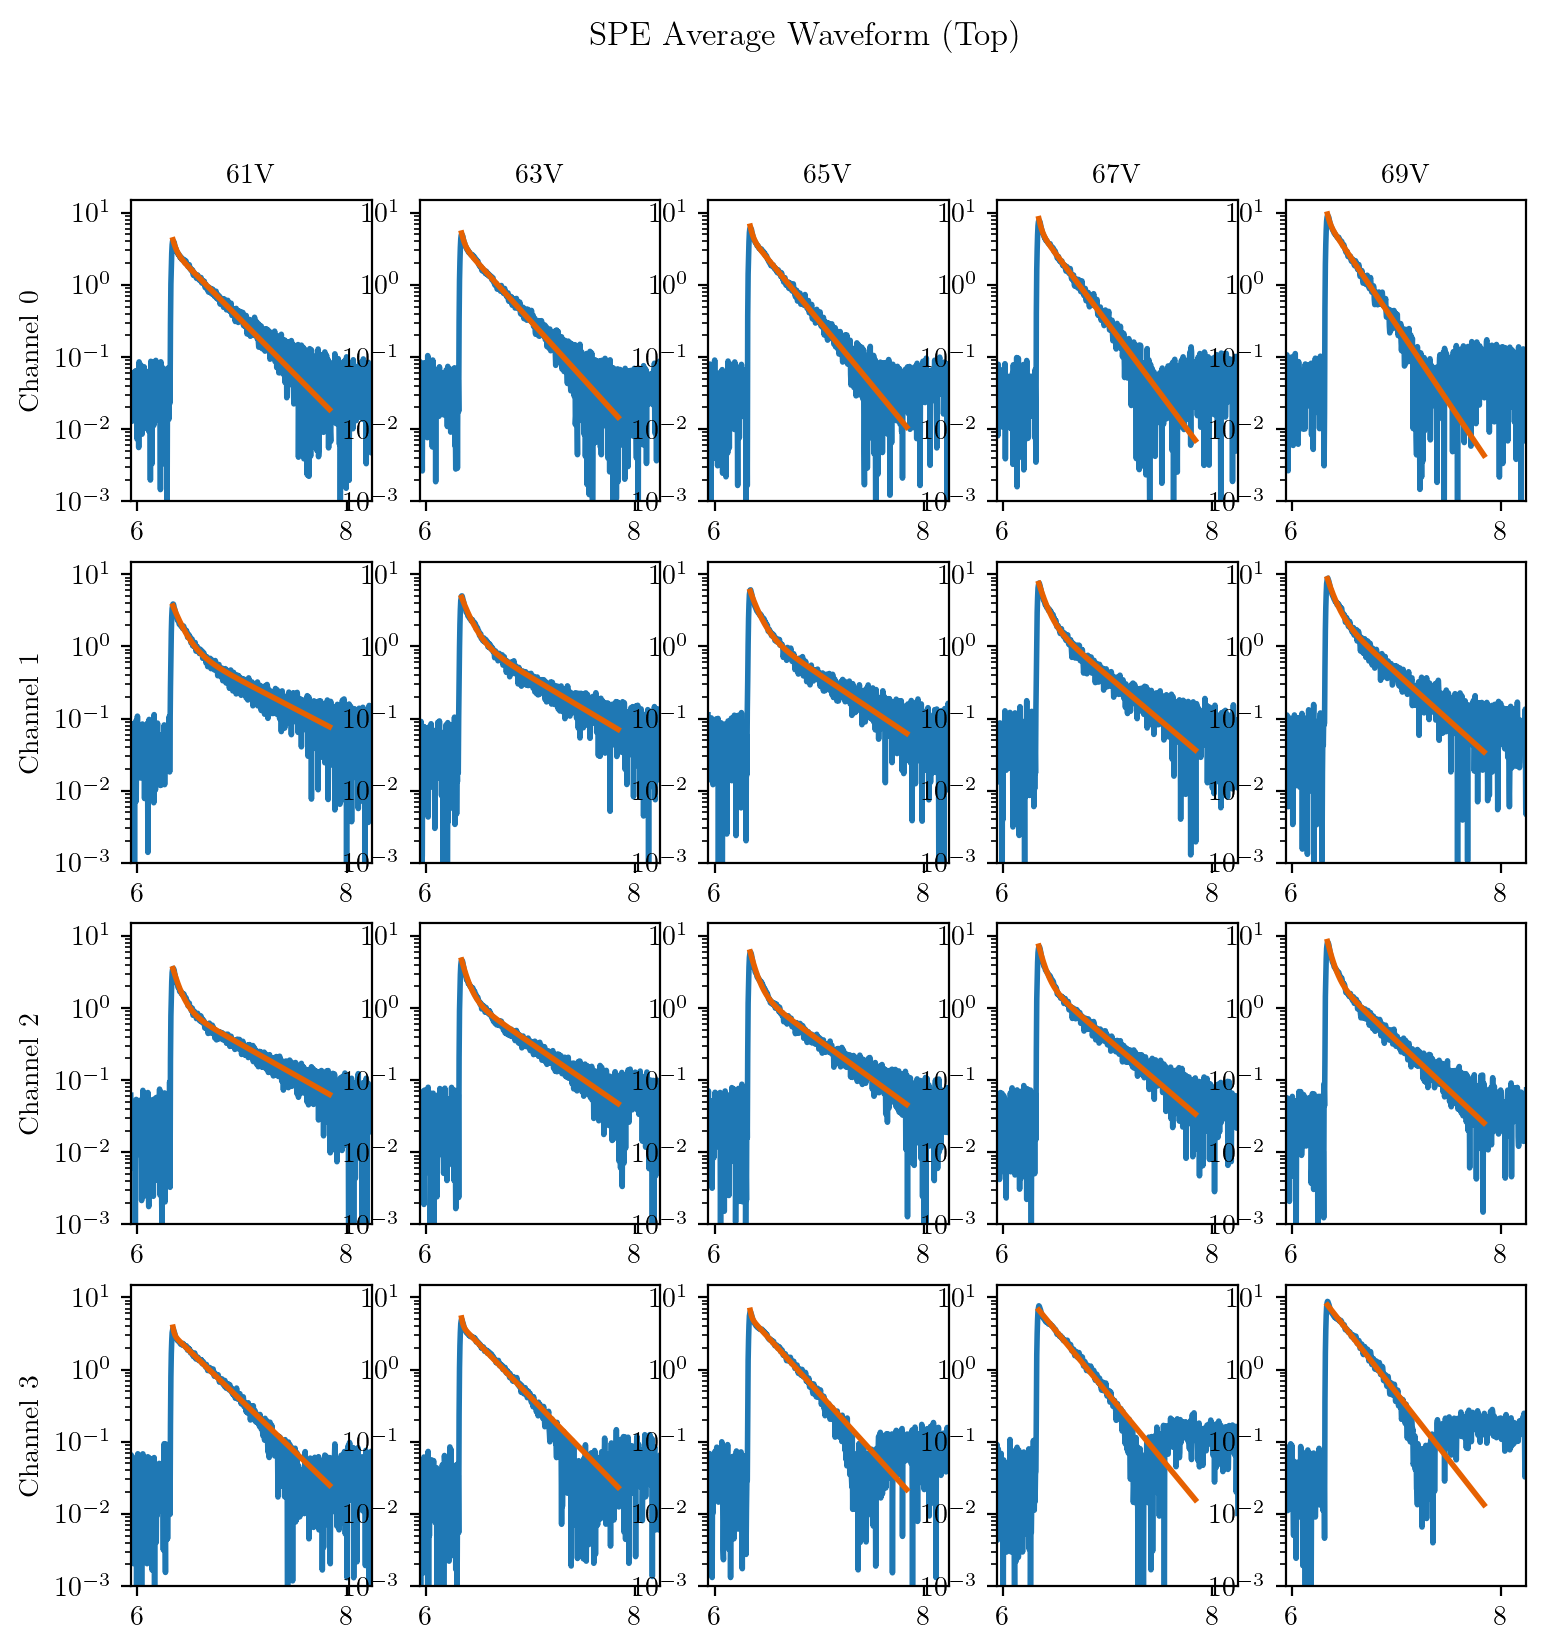

In [10]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for ch in range(4):
    spe_integral = []
    for i,data in enumerate(datasets_top):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        t_start = int(data.ch[ch].trigger_position)
        t_end = int(data.ch[ch].trigger_position + 1.5/data.ch[ch].sample_step)
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[3,0.08,3,0.5], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        data.ch[ch].set_pulse_pars(a1=[popt[0],np.sqrt(pcov[0,0])], tau1=[popt[1],np.sqrt(pcov[1,1])], a2=[popt[2],np.sqrt(pcov[2,2])], tau2=[popt[3],np.sqrt(pcov[3,3])])
        plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Top)')
plt.savefig('plots/sipm/spewf_top_1101.pdf')

# Bottome tile calibration (1101 data)

## Directories

In [11]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/'
bias = [61, 63, 65, 67, 69]
subdir = ['2022-11-01_volt_{}_pos_bottom_light_laser_coinc_none_cond_calibration/'.format(bias_) for bias_ in bias]

In [12]:
datasets_bot = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=4000)
    print(path)
    for i in range(4):
        data.ch[i].read_data(header=True)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].clear()
    datasets_bot.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_61_pos_bottom_light_laser_coinc_none_cond_calibration/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_63_pos_bottom_light_laser_coinc_none_cond_calibration/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_65_pos_bottom_light_laser_coinc_none_cond_calibration/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_67_pos_bottom_light_laser_coinc_none_cond_calibration/
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/2022-11-01_volt_69_pos_bottom_light_laser_coinc_none_cond_calibration/


## Plot charge histogram and analyze

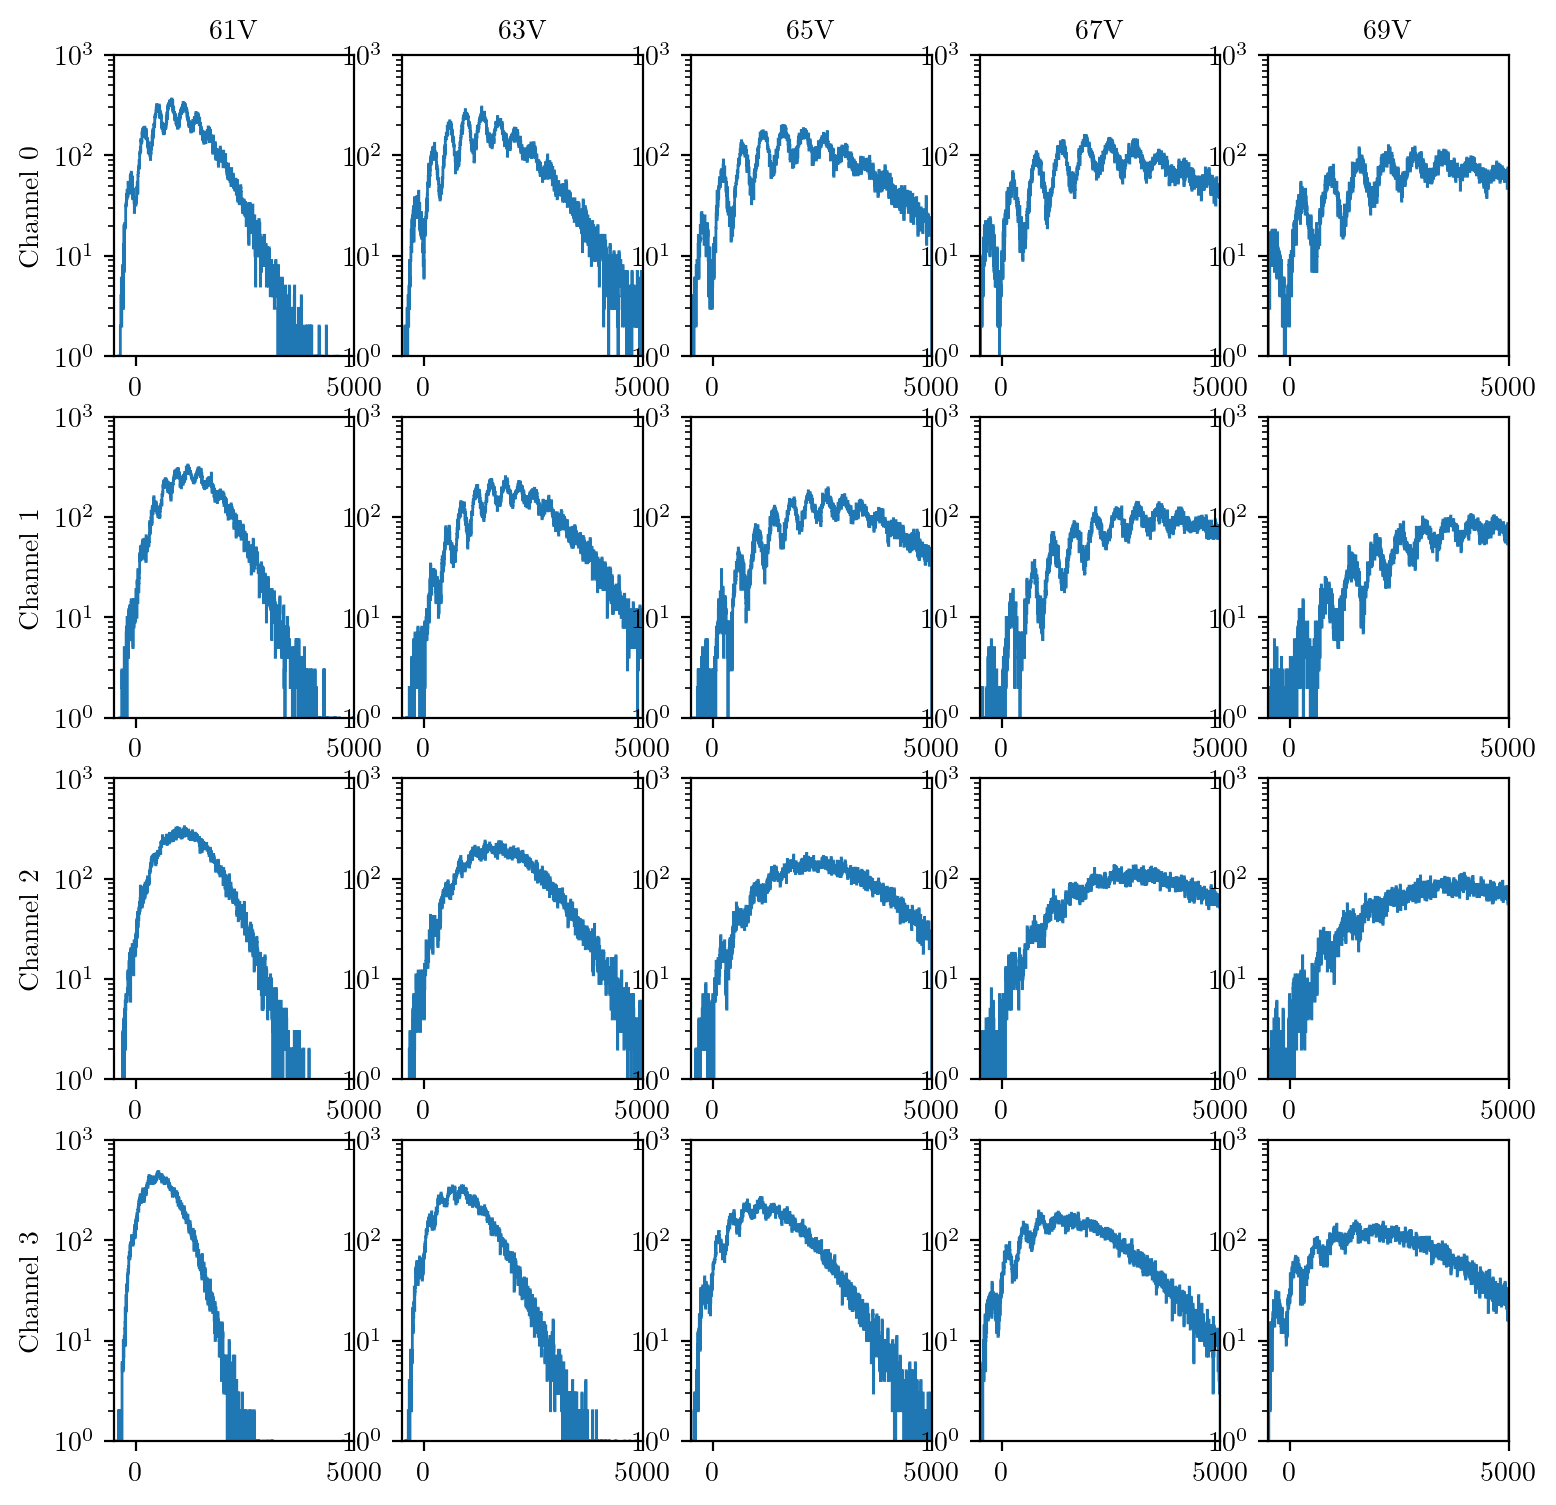

In [13]:
plt.figure(0,figsize=(9,9)) #for charge histograms
# plt.figure(1,figsize=(9,3)) #for breakdown voltage fit
# Vbd_charge_plt.figure(0,figsize=(9,9)) #for charge histograms
# plt.figure(1,figsize=(9,3)) #for breakdown voltage fit
# Vbd_charge_bot = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_bot):
        #charge histogram
        data.ch[ch].get_integral_hist(short=[-5e2,5e3,1000], long=[-5e2,5e3,1000])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_short_hist, data.ch[ch].integral_short_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].integral_short_hist_bin[0], data.ch[ch].integral_short_hist_bin[-1])
        plt.ylim(1, 1e3)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='integral_short', thre=100, prom=10, wid=10, dist=10)
        # fit pe peaks with Gaussian
        # min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='integral_short')
        # npe = len(data.ch[ch].integral_short_hist_fit)
        # for ipe in range(npe):
        #     popt = [data.ch[ch].integral_short_hist_fit[ipe][ipar][0] for ipar in range(3)]
        #     plt.plot(data.ch[ch].integral_short_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].integral_short_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        # Ishort = [[data.ch[ch].integral_short_hist_fit[k][1][0], data.ch[ch].integral_short_hist_fit[k][1][1]] for k in range(npe)]
        # xlin = np.linspace(1,npe,npe)
        # ylin = np.array(Ishort)[:,0]
        # popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Ishort)[:,1], maxfev=10000)
    #breakdown voltage fit and plot
    # xlin = bias
    # ylin = [data.ch[ch].gain_integral[0] for data in datasets_bot]
    # err = [data.ch[ch].gain_integral[1] for data in datasets_bot]
    # popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], sigma=err, maxfev=10000)
    # print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    # Vbd_charge_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    # plt.figure(1)
    # plt.subplot(1,4,ch+1)
    # plt.title('Channel {}'.format(ch))
    # plt.ylabel('Gain (A.U.)')
    # plt.xlabel('Bias (V)')
    # plt.errorbar(xlin,ylin,yerr=err,fmt='o',markersize=2)
    # plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    # plt.xlim(50,80)
    # plt.ylim(0,1000)

## Plot filtered amplitude histogram and analyze
Ch2 is quite noisy so it is excluded.

mu=3.588 p=0.092
mu=4.131 p=0.123
mu=4.543 p=0.177
mu=4.570 p=0.243
mu=4.695 p=0.321
Channel 0 Vbd=55.061+/-0.084V slope=8.957+/-0.079
mu=5.277 p=0.070
mu=5.917 p=0.125
mu=6.484 p=0.172
mu=6.588 p=0.221
mu=6.836 p=0.257
Channel 1 Vbd=55.007+/-0.117V slope=7.975+/-0.089
mu=3.305 p=0.078
mu=3.762 p=0.109
mu=4.077 p=0.176
mu=4.152 p=0.221
mu=4.273 p=0.283
Channel 3 Vbd=55.136+/-0.036V slope=7.257+/-0.026


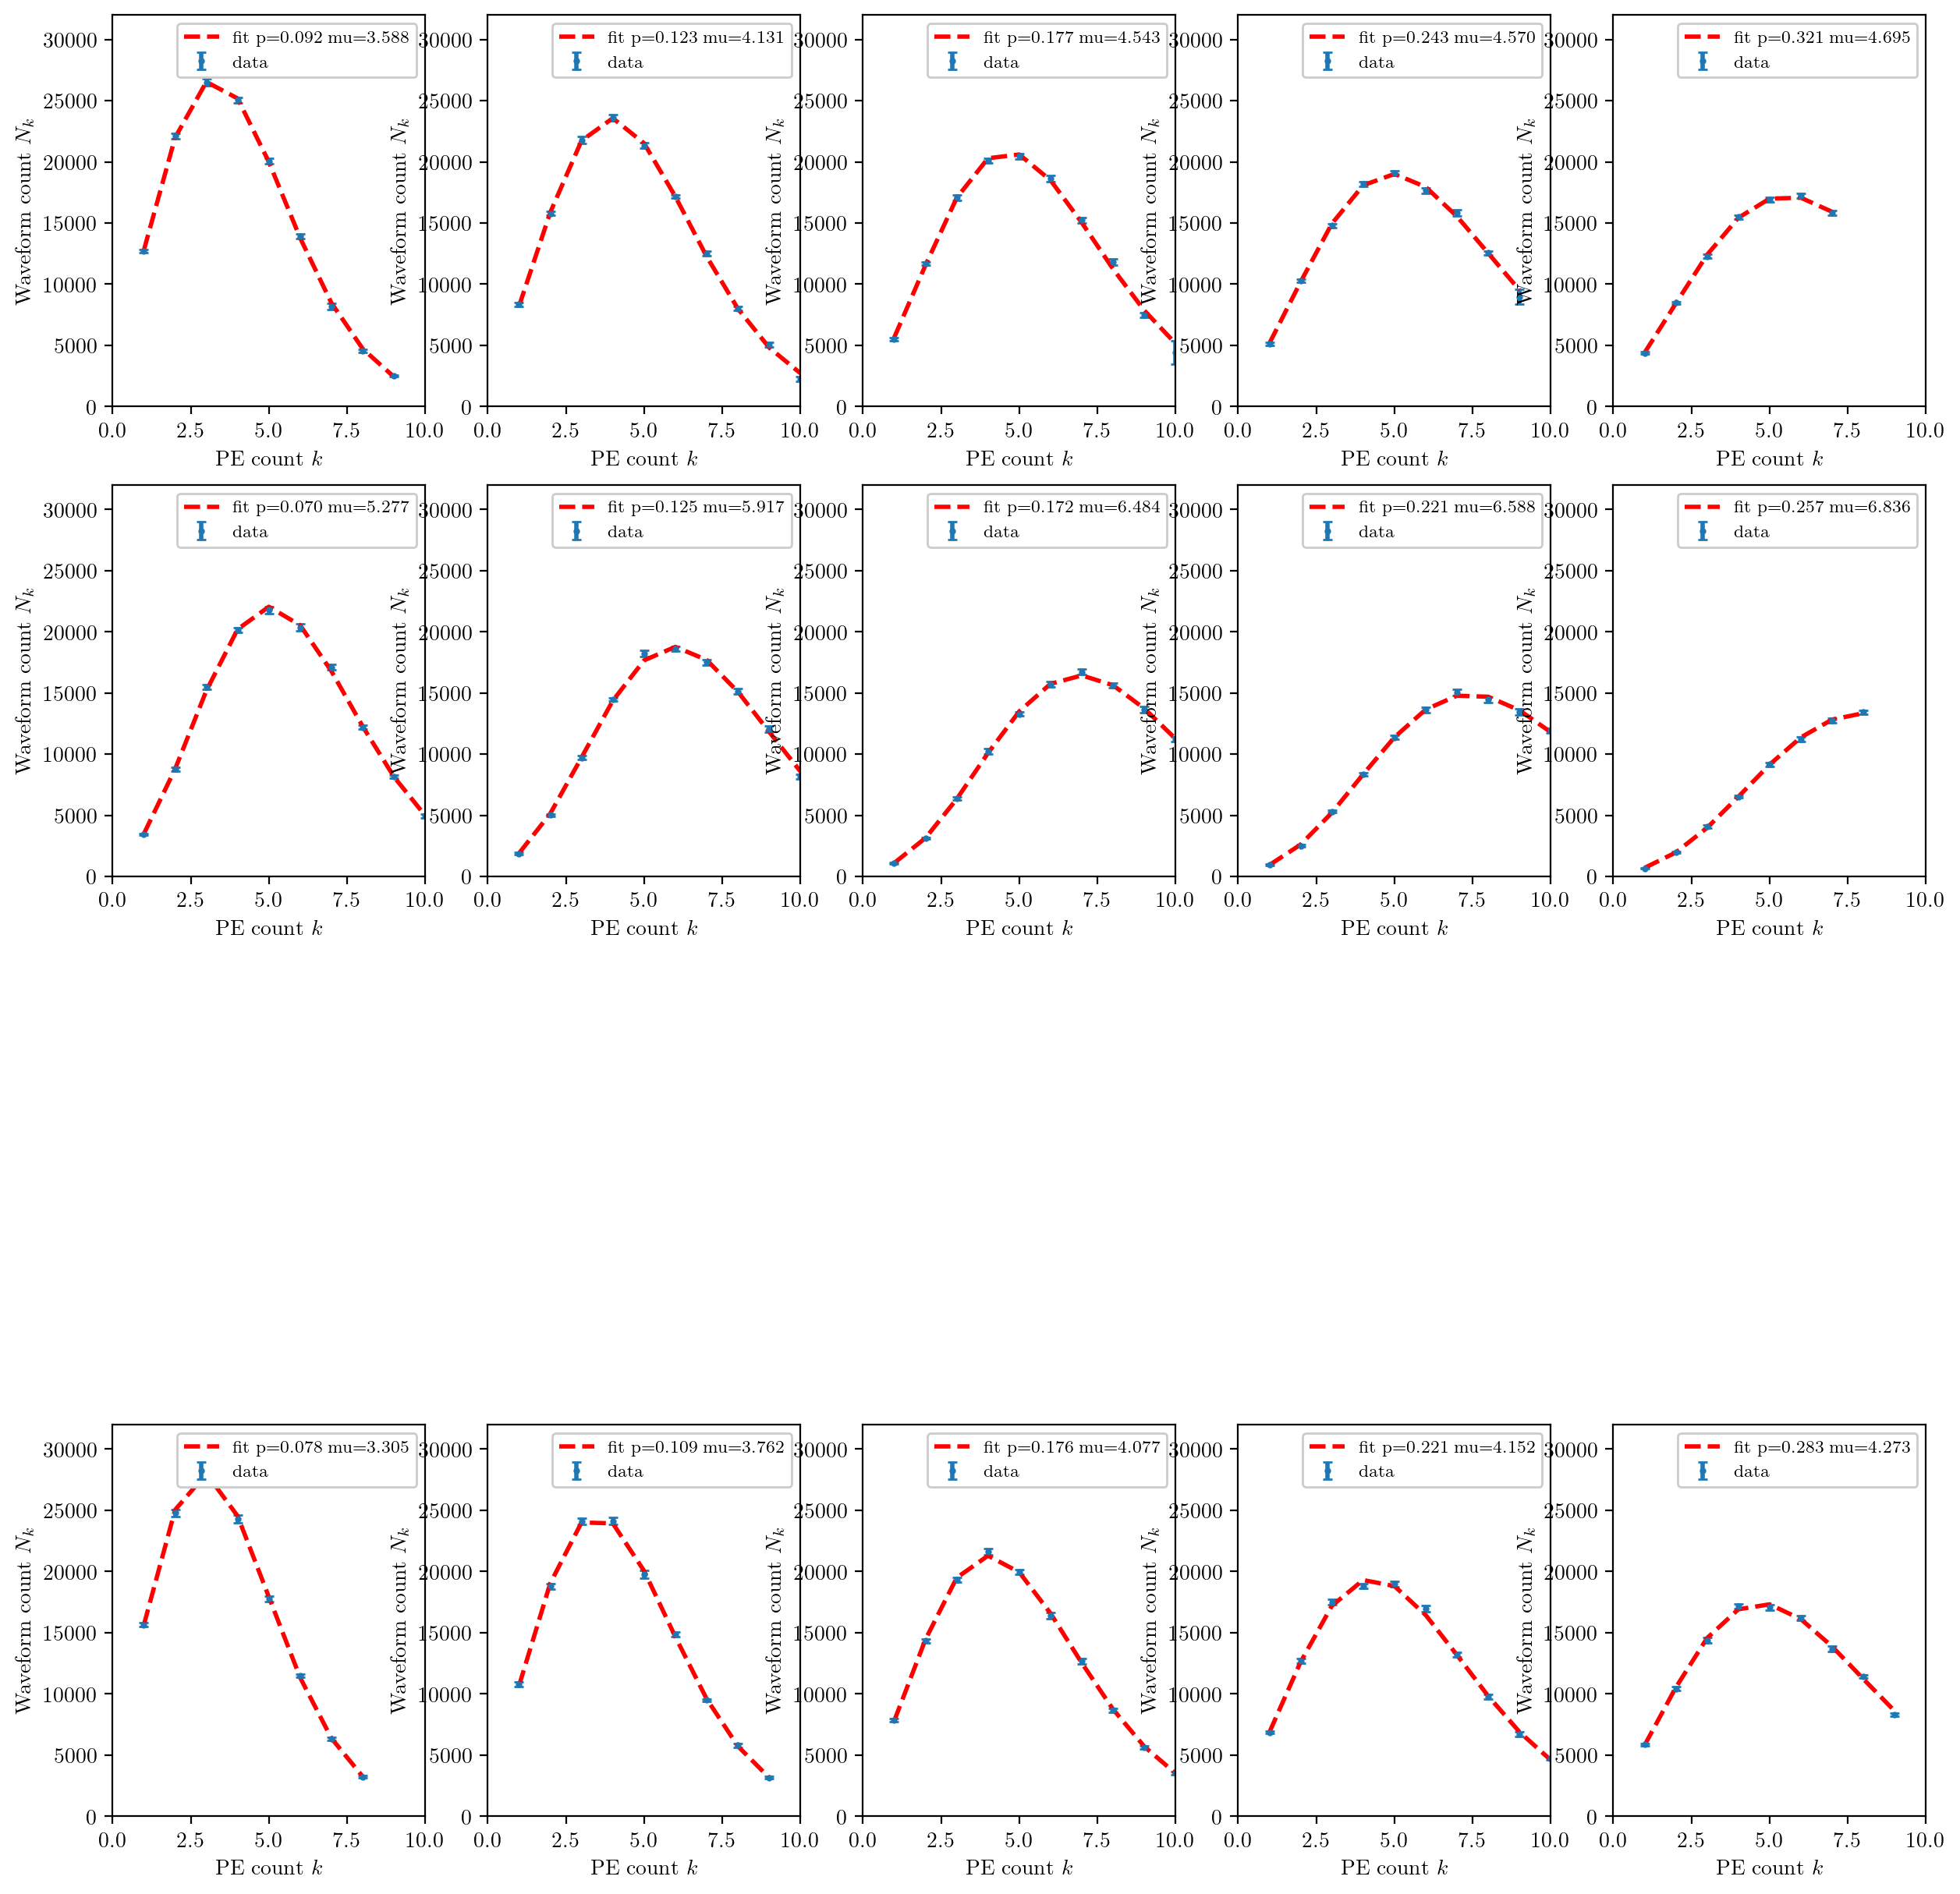

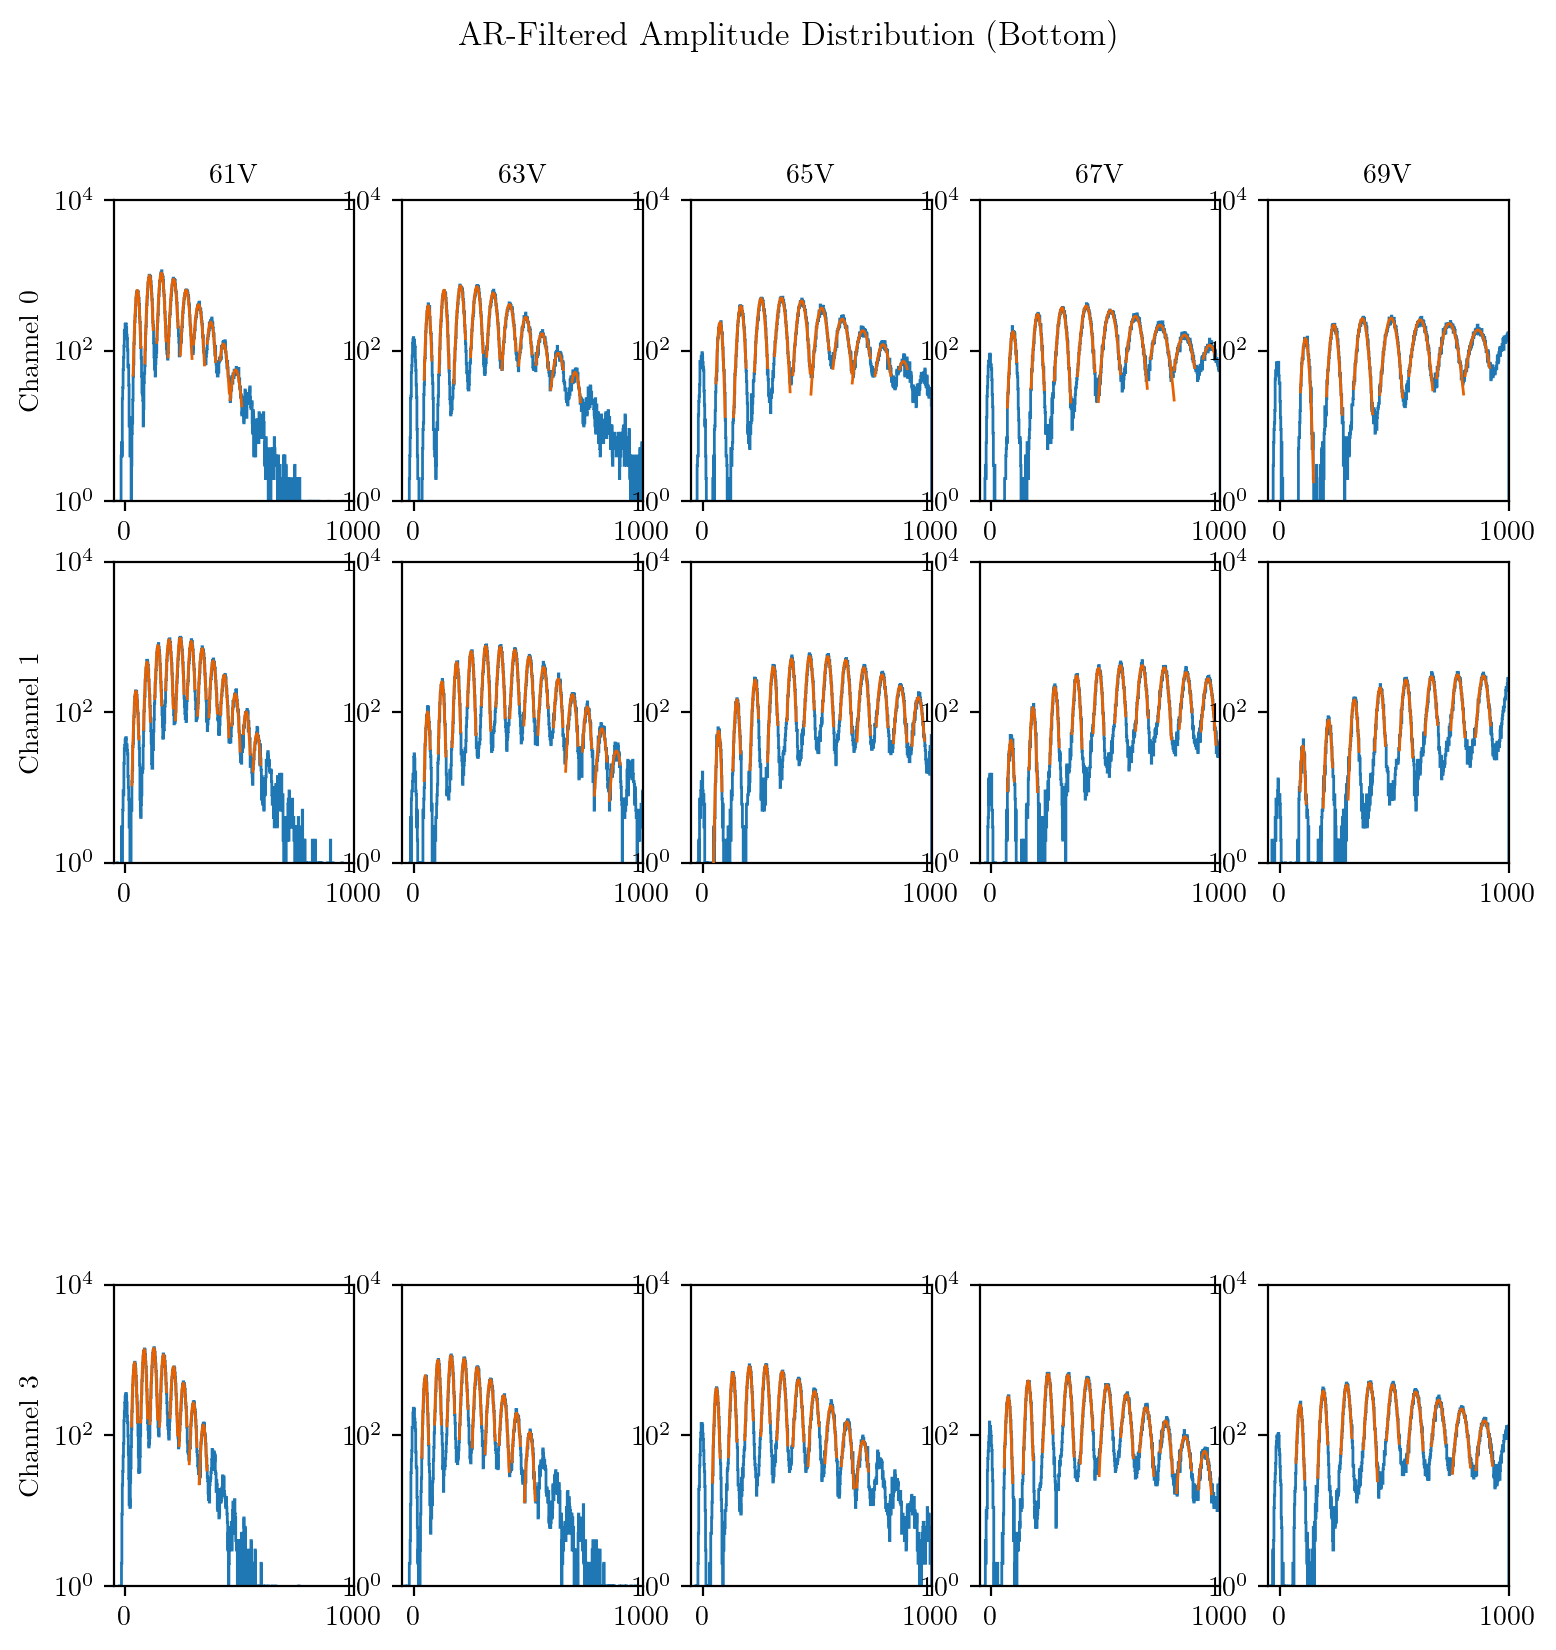

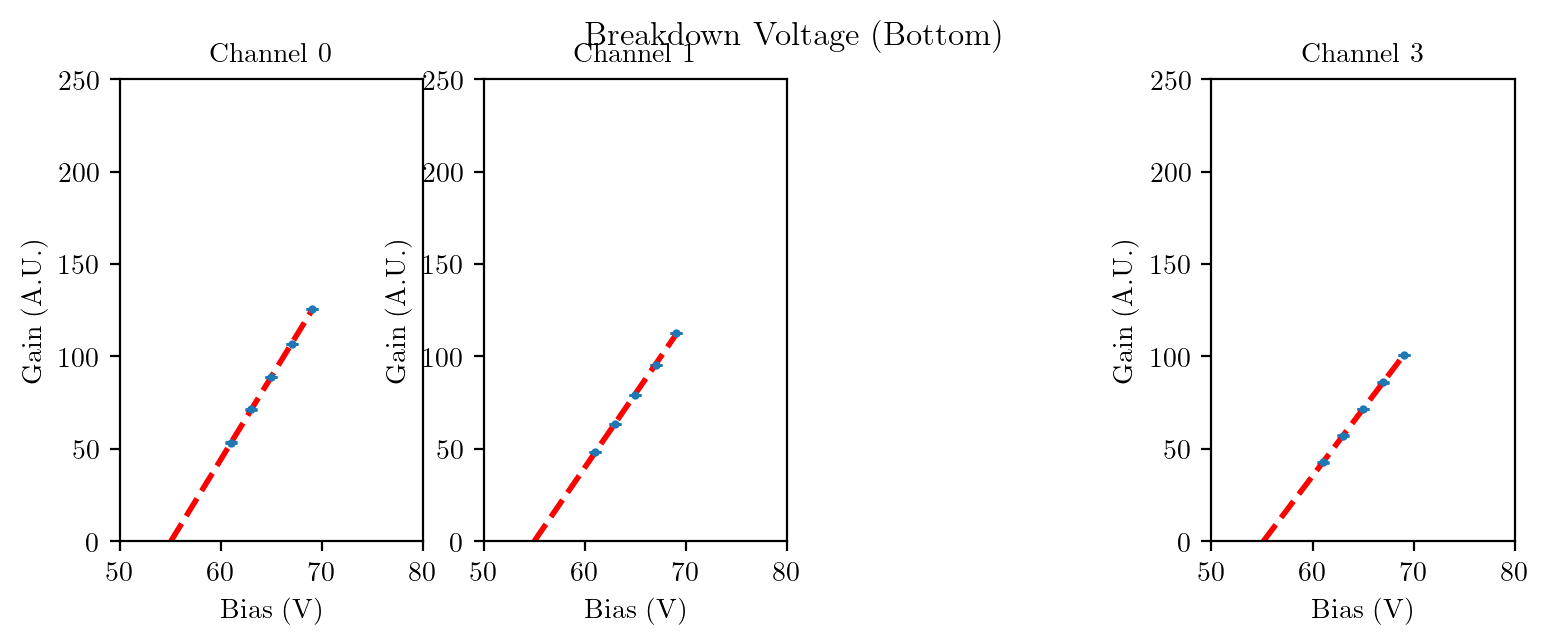

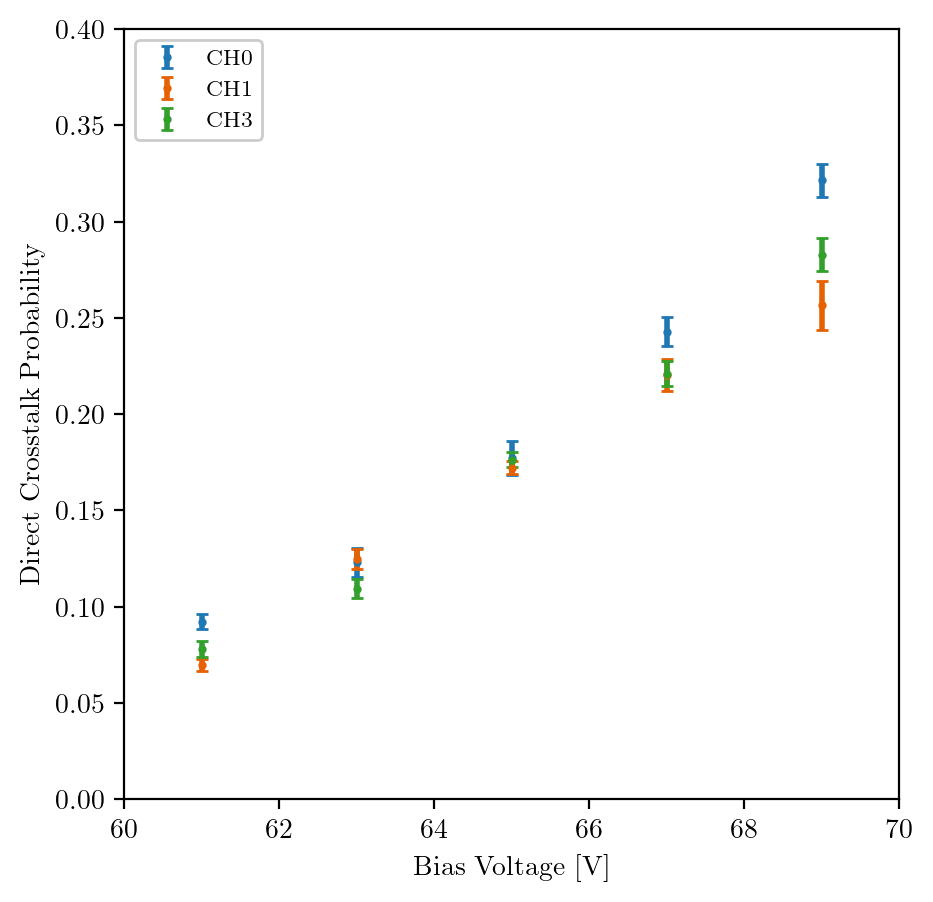

In [14]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
Vbd_famp_bot = np.zeros((4,2))
for ch in [0,1,3]:
    for i,data in enumerate(datasets_bot):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[-50,1e3,600])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=40, prom=30, wid=8, dist=8)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        npe = len(data.ch[ch].famp_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Afilt)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[data.ch[ch].nevents, 5, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
        print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,0.4*data.ch[ch].nevents)
        plt.xlim(0,10)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in datasets_bot], yerr=[data.ch[ch].ct[1] for data in datasets_bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_a[0] for data in datasets_bot]
    err = [data.ch[ch].q_a[1] for data in datasets_bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
plt.savefig('plots/sipm/famp_histo_bot_1101.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_famp_bot_1101.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(60,70)
plt.ylim(0, 0.4)
plt.savefig('plots/sipm/dict_bot_1101.pdf')

## Examine after-pulses
Time window = $5~\rm\mu s$.
$\mu$ of Gaussian fit is regarded as the spe gain, while the overall average is $\mu(1+ap)$ where $ap$ is the afterpulse charge per pe.
The right tails are due to afterpulses.


Channel 0 Vbd=54.081+/-0.340V slope=47.824+/-1.559


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Channel 1 Vbd=53.622+/-0.074V slope=45.254+/-0.338
Channel 3 Vbd=54.358+/-0.237V slope=42.468+/-0.949


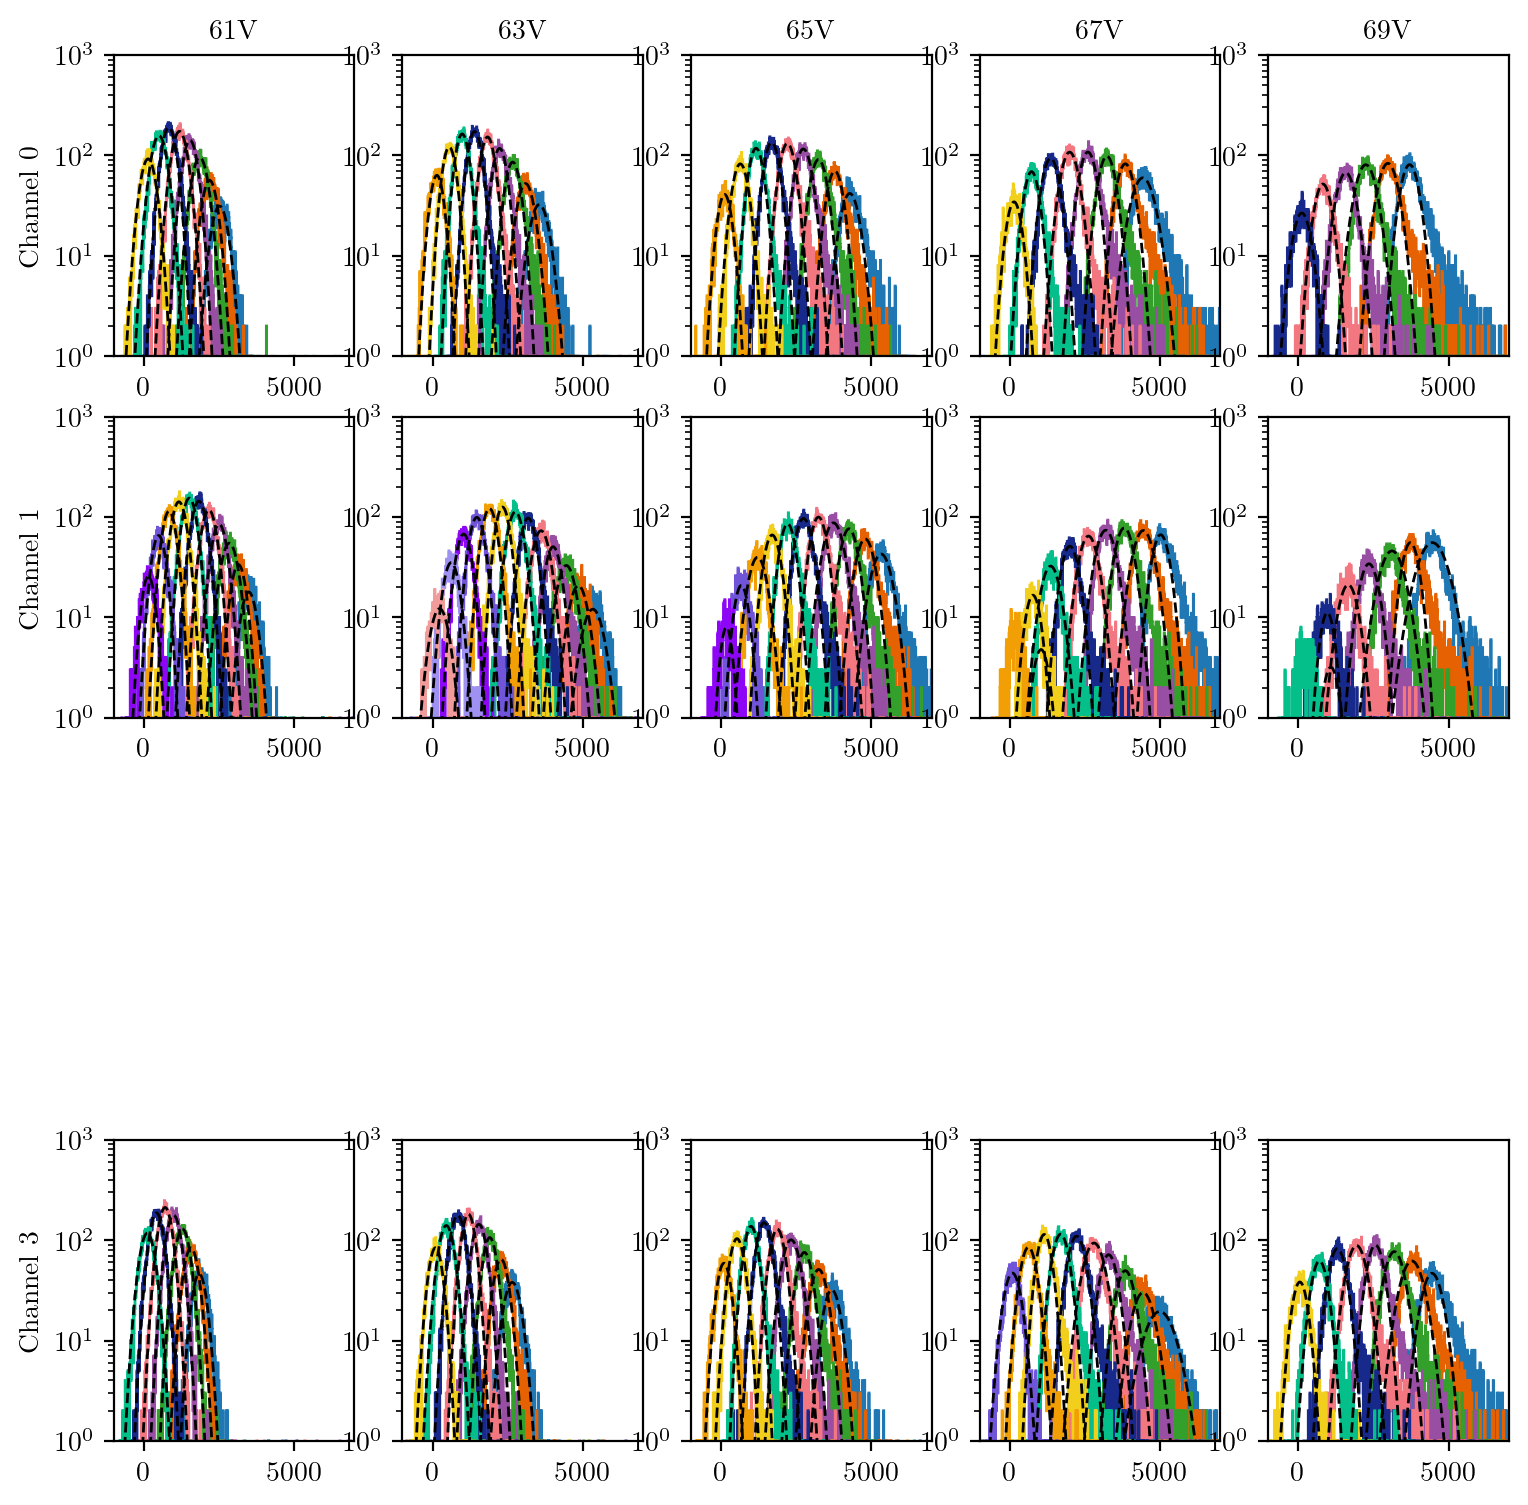

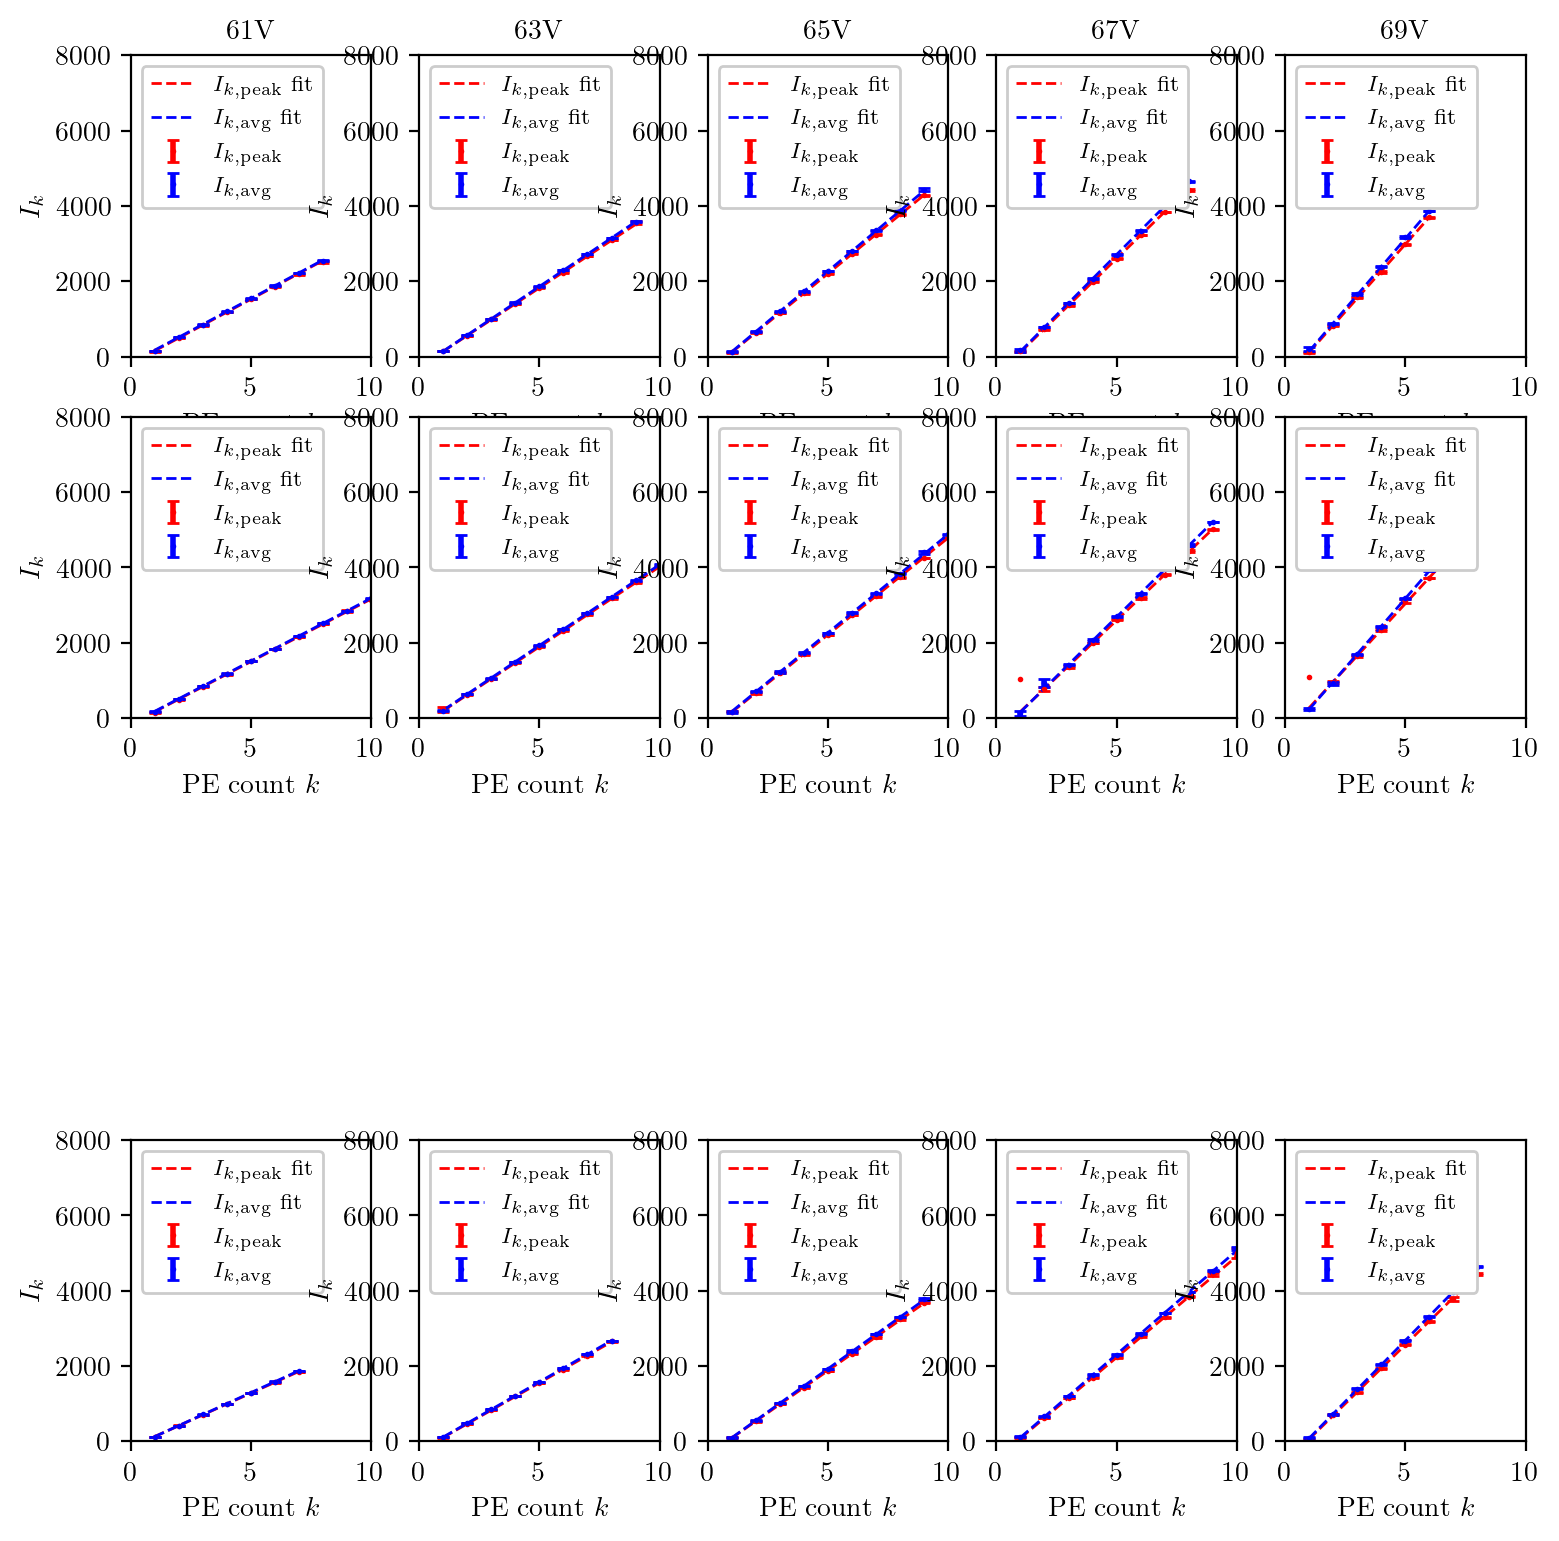

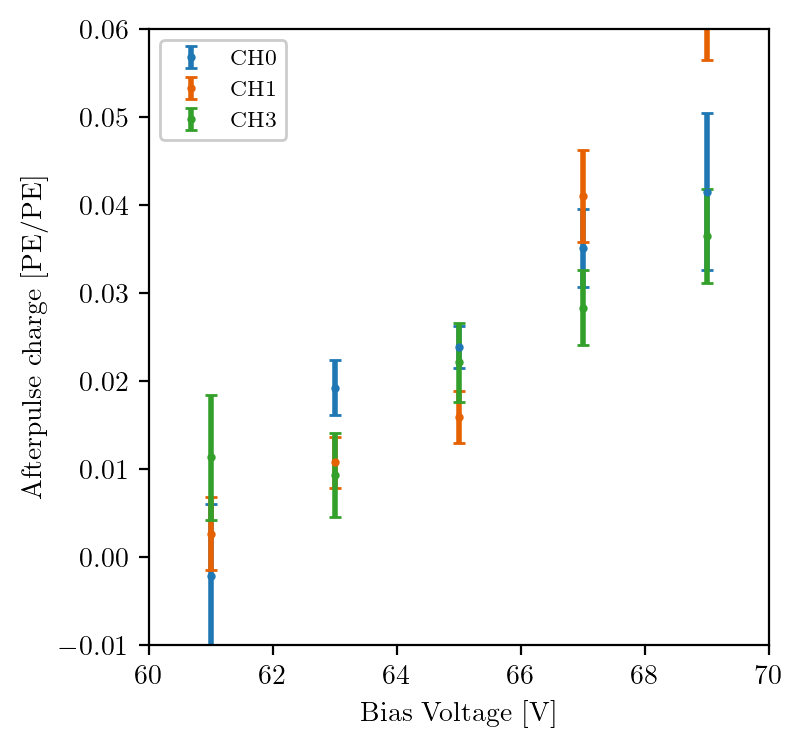

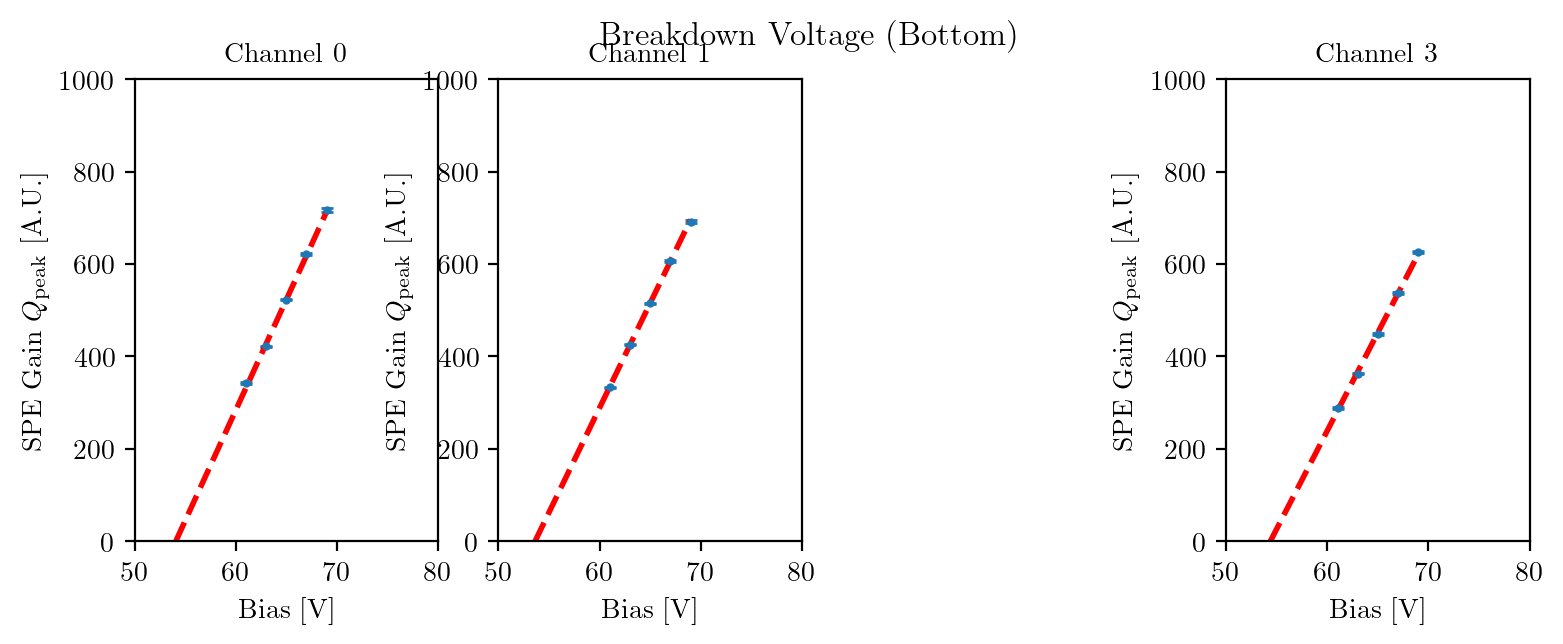

In [15]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
Vbd_charge_bot = np.zeros((4,2))
x_min=-1000
x_max=7000
n_bins=1000
bin_width = (x_max-x_min)/n_bins
for ch in [0,1,3]:
    for i,data in enumerate(datasets_bot):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(nsigma=2, bin=[x_min, x_max, n_bins])
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            if w>0.1*(p+x_min/bin_width):
                w=30 # something weird happened so I need to do this
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,1e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in datasets_bot], yerr=[data.ch[ch].ap[1] for data in datasets_bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in datasets_bot]
    err = [data.ch[ch].q_peak[1] for data in datasets_bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(60,70)
plt.ylim(-0.01, 0.06)
plt.savefig('plots/sipm/afterpulse_bias_bot_1101.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_charge_bot_1101.pdf')

# Breakdown voltage summary

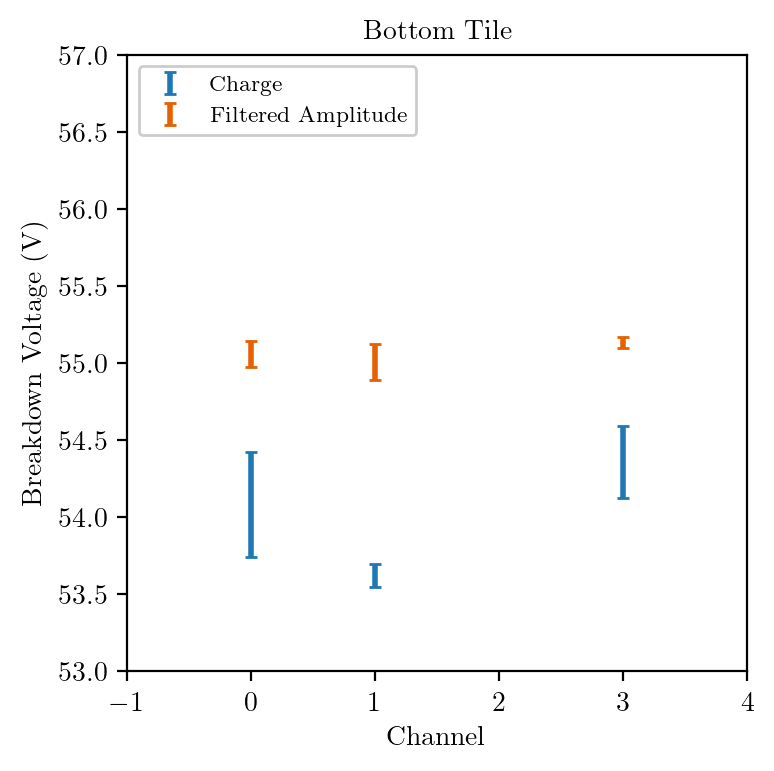

<Figure size 800x600 with 0 Axes>

In [16]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_bot[:,0], yerr=Vbd_charge_bot[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_bot[:,0], yerr=Vbd_famp_bot[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Bottom Tile')
plt.legend()
plt.show()
plt.savefig('plots/sipm/vbd_bot_1101.pdf')

## SPE average waveform

CH0 61V  A1=1.708+/-0.052 TAU1=0.0433+/-0.0026us A2=2.072+/-0.043 TAU2=0.3430+/-0.0064us
CH0 63V  A1=2.251+/-0.058 TAU1=0.0386+/-0.0020us A2=2.503+/-0.048 TAU2=0.3077+/-0.0052us
CH0 65V  A1=2.763+/-0.079 TAU1=0.0334+/-0.0019us A2=3.256+/-0.065 TAU2=0.2664+/-0.0048us
CH0 67V  A1=3.614+/-0.112 TAU1=0.0327+/-0.0020us A2=4.121+/-0.100 TAU2=0.2364+/-0.0049us
CH0 69V  A1=3.554+/-0.143 TAU1=0.0331+/-0.0025us A2=5.332+/-0.137 TAU2=0.2118+/-0.0044us
CH1 61V  A1=2.666+/-0.037 TAU1=0.0728+/-0.0020us A2=0.814+/-0.031 TAU2=0.6193+/-0.0232us
CH1 63V  A1=3.590+/-0.049 TAU1=0.0663+/-0.0018us A2=1.099+/-0.042 TAU2=0.5324+/-0.0187us
CH1 65V  A1=4.289+/-0.061 TAU1=0.0574+/-0.0016us A2=1.512+/-0.057 TAU2=0.3902+/-0.0123us
CH1 67V  A1=5.397+/-0.084 TAU1=0.0528+/-0.0015us A2=1.989+/-0.082 TAU2=0.3247+/-0.0106us
CH1 69V  A1=6.412+/-0.093 TAU1=0.0626+/-0.0017us A2=1.854+/-0.089 TAU2=0.4042+/-0.0159us
CH3 61V  A1=2.774+/-0.038 TAU1=0.0721+/-0.0019us A2=0.488+/-0.037 TAU2=0.4821+/-0.0306us
CH3 63V  A1=3.396+/-0

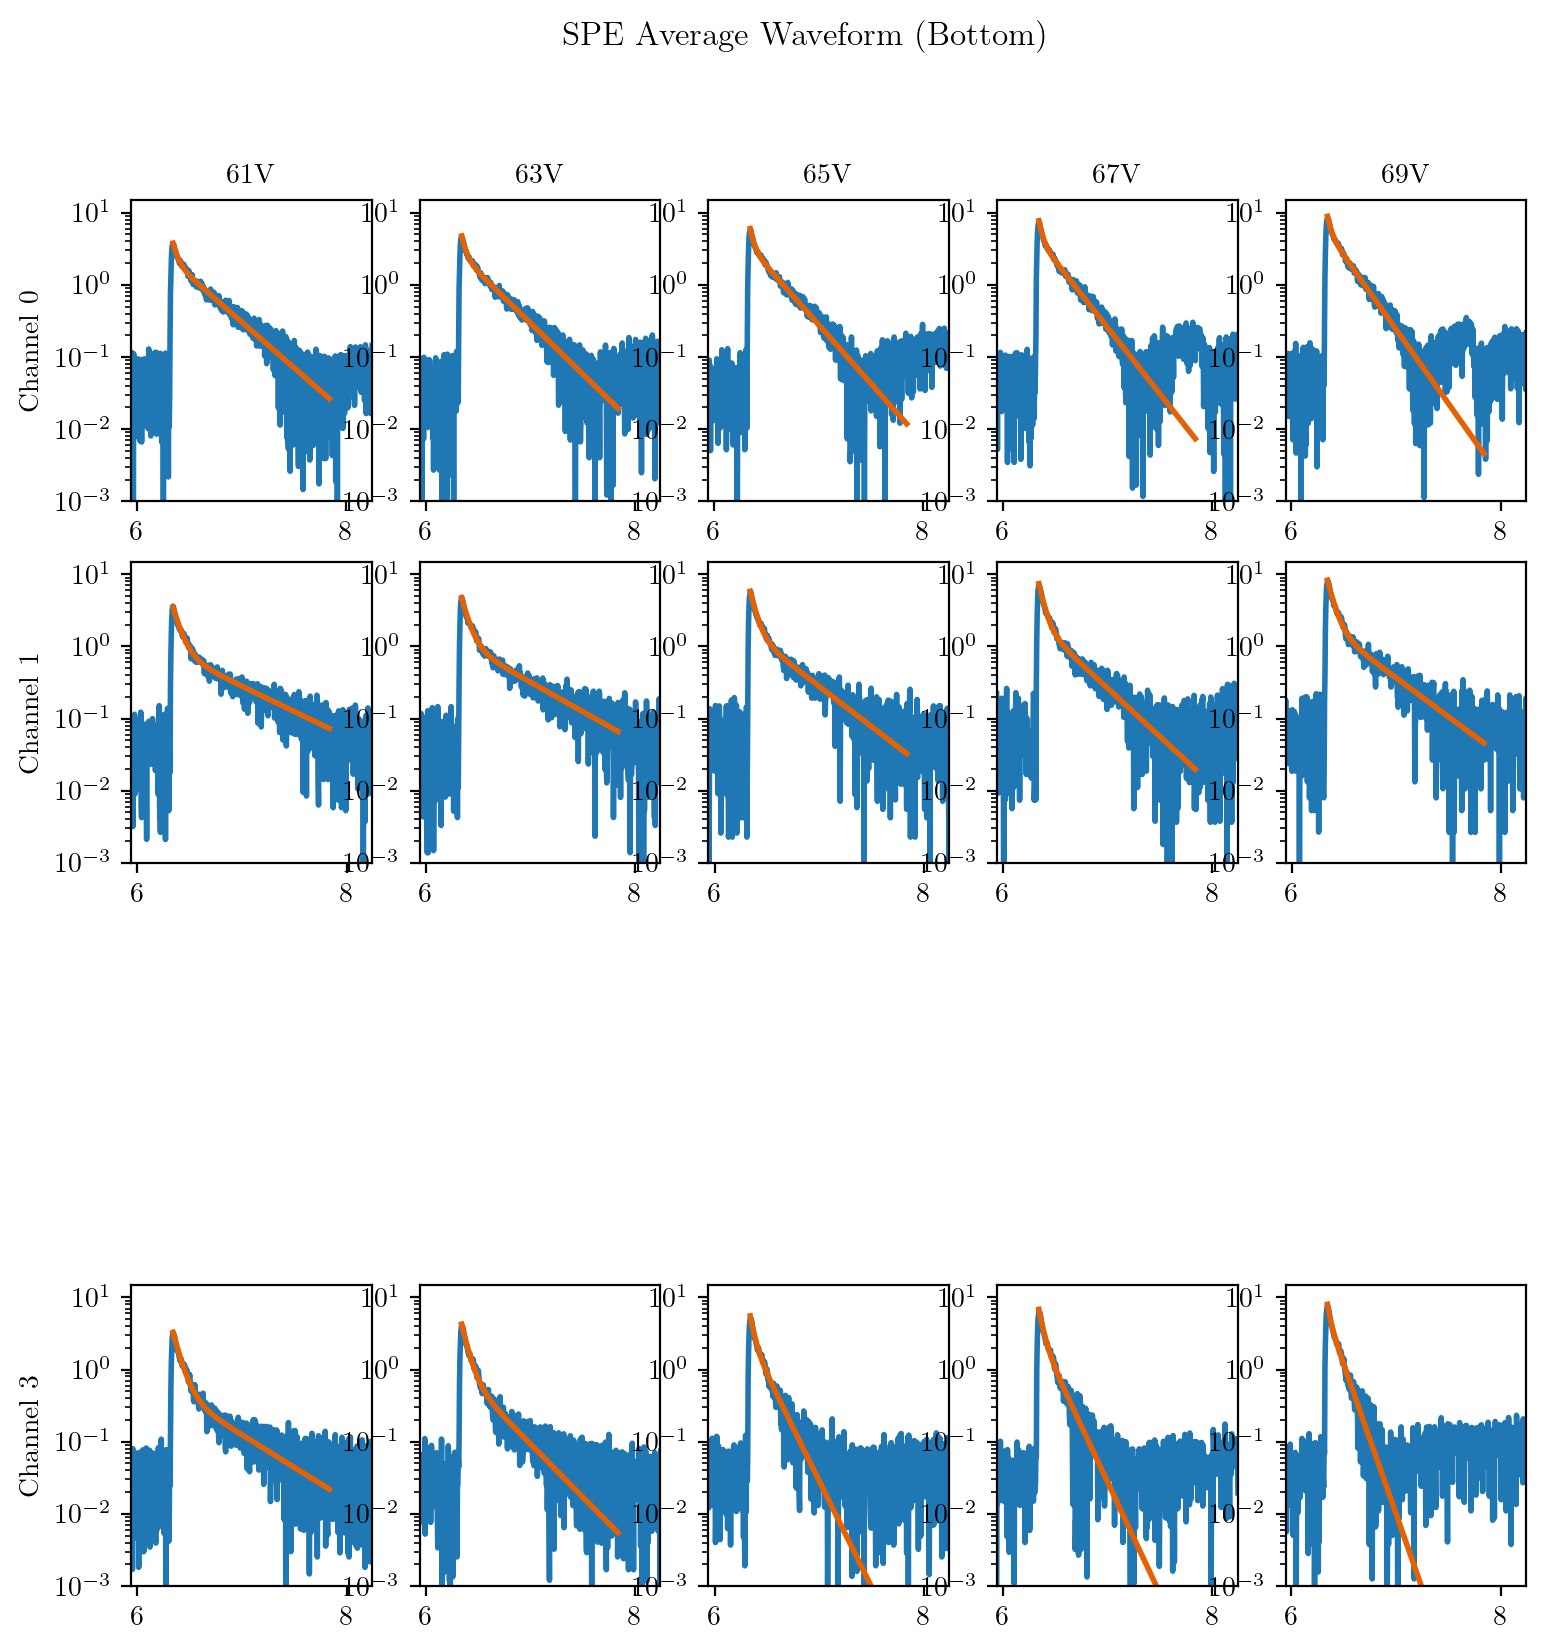

In [17]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for ch in [0,1,3]:
    spe_integral = []
    for i,data in enumerate(datasets_bot):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        t_start = int(data.ch[ch].trigger_position)
        t_end = int(data.ch[ch].trigger_position + 1.5/data.ch[ch].sample_step)
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[3,0.08,3,0.5], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        data.ch[ch].set_pulse_pars(a1=[popt[0],np.sqrt(pcov[0,0])], tau1=[popt[1],np.sqrt(pcov[1,1])], a2=[popt[2],np.sqrt(pcov[2,2])], tau2=[popt[3],np.sqrt(pcov[3,3])])
        plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
plt.savefig('plots/sipm/spewf_bot_1101.pdf')